# Plot and visualize peaks

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


In [3]:
config = load_global_config()
common.plot_utils.set_style()

# DiffMS Leu vs Ile

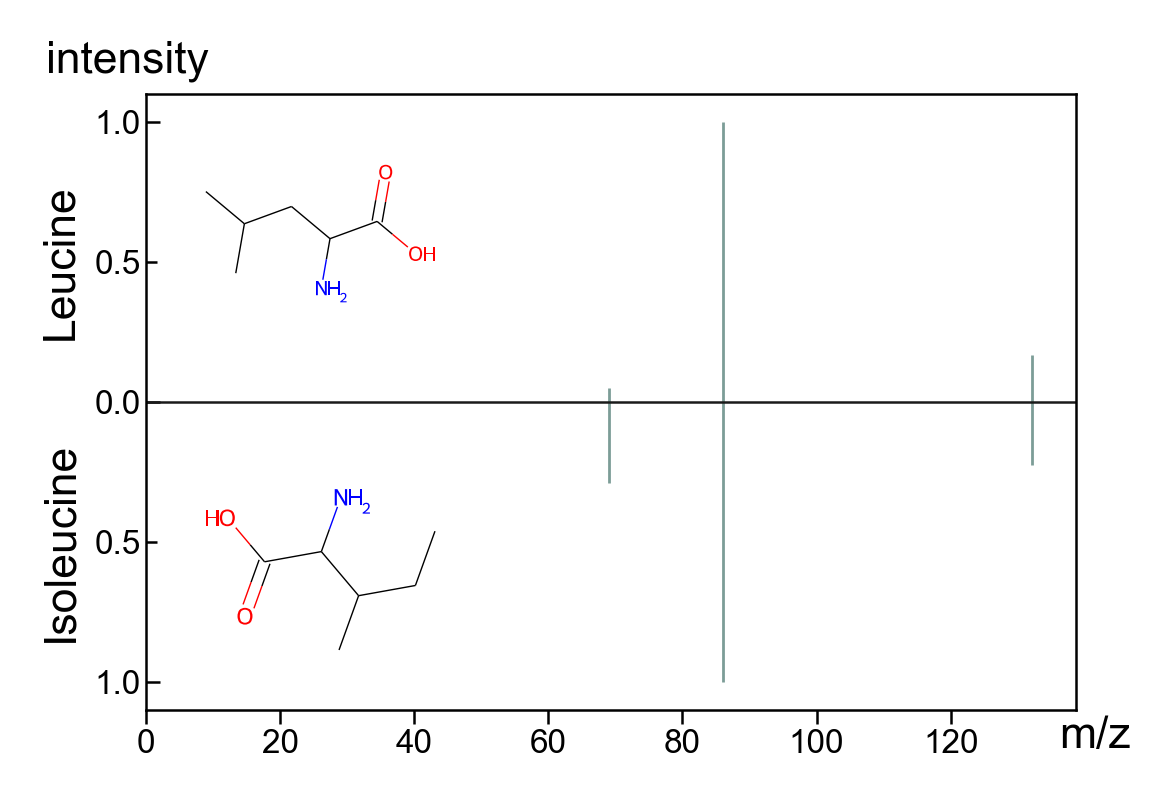

In [38]:
leu_spec = load_real_spec('nist_1250935', 'nist')
isoleu_spec = load_real_spec('nist_1188546', 'nist')

plt.figure(figsize=(3, 2), dpi=400)
ax = plt.gca()
common.plot_compare_ms(leu_spec['13'], isoleu_spec['13'], 'Leucine', 'Isoleucine', ax=ax, ppm=50)
# plt.savefig('leu-ile.pdf')
common.plot_mol_as_vector(Chem.MolFromSmiles('CC(C)CC(N)C(=O)O'), ax=ax, offset=(130/5, 0.6), zoom=0.003)
common.plot_mol_as_vector(Chem.MolFromSmiles('CCC(C)C(N)C(=O)O'), ax=ax, offset=(130/5, -0.6), zoom=0.003)

In [4]:
# Only show peak predictions
def visual_preds(pred_smi, colli_energies=[10, 20, 30, 40, 50], nce=False, merge_ces=False, explain_npeaks=0, name="", **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = nce  # use nce for collision energy
    _config['merge_spec'] = merge_ces # merge spec for visualization
    for k, v in kwargs.items():
        _config[k] = v

    # Get candidates
    smiles = [pred_smi]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, colli_energies, **_config)

    # Visualize and explain peaks
    if merge_ces:
        fig = plt.figure(figsize=(3, 1.5), dpi=500)
        axes = plt.gca()
    else:
        fig, axes = plt.subplots(len(colli_energies), 1, figsize=(3, 1. * len(colli_energies)), dpi=500)
        #fig, axes = plt.subplots(len(colli_energies), 1, figsize=(2, 1.5 * len(colli_energies)), dpi=500)
    explain_peaks(result_path, None, pmz, pred_smi, num_peaks=explain_npeaks, axes=axes, save_path=f'{name}.pdf', **_config)


# Fig1 prediction

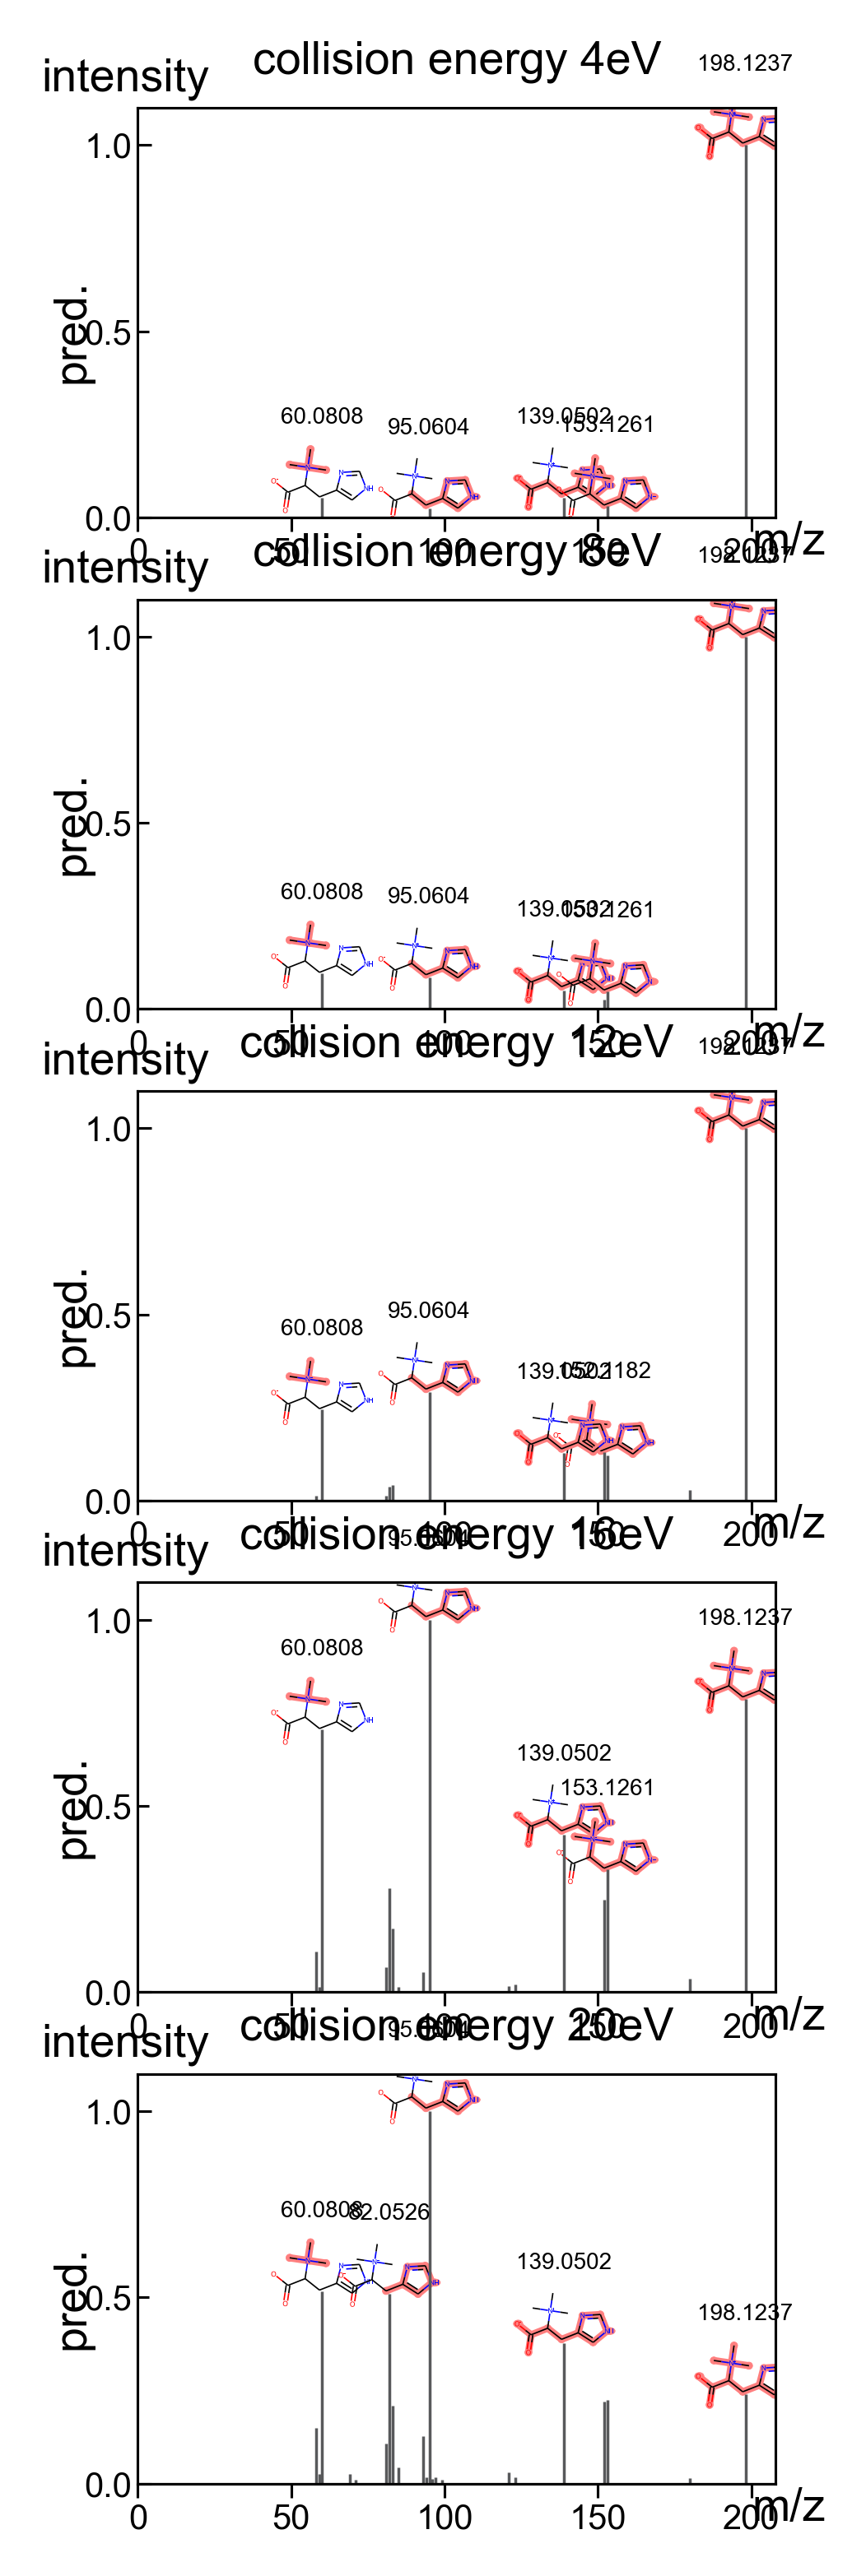

In [37]:
# manually change figsize to (2, 1.5)
visual_preds(r'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]', np.arange(10, 51, 10), nce=True, explain_npeaks=5, name='hercynine')

## Fig2 collision energies

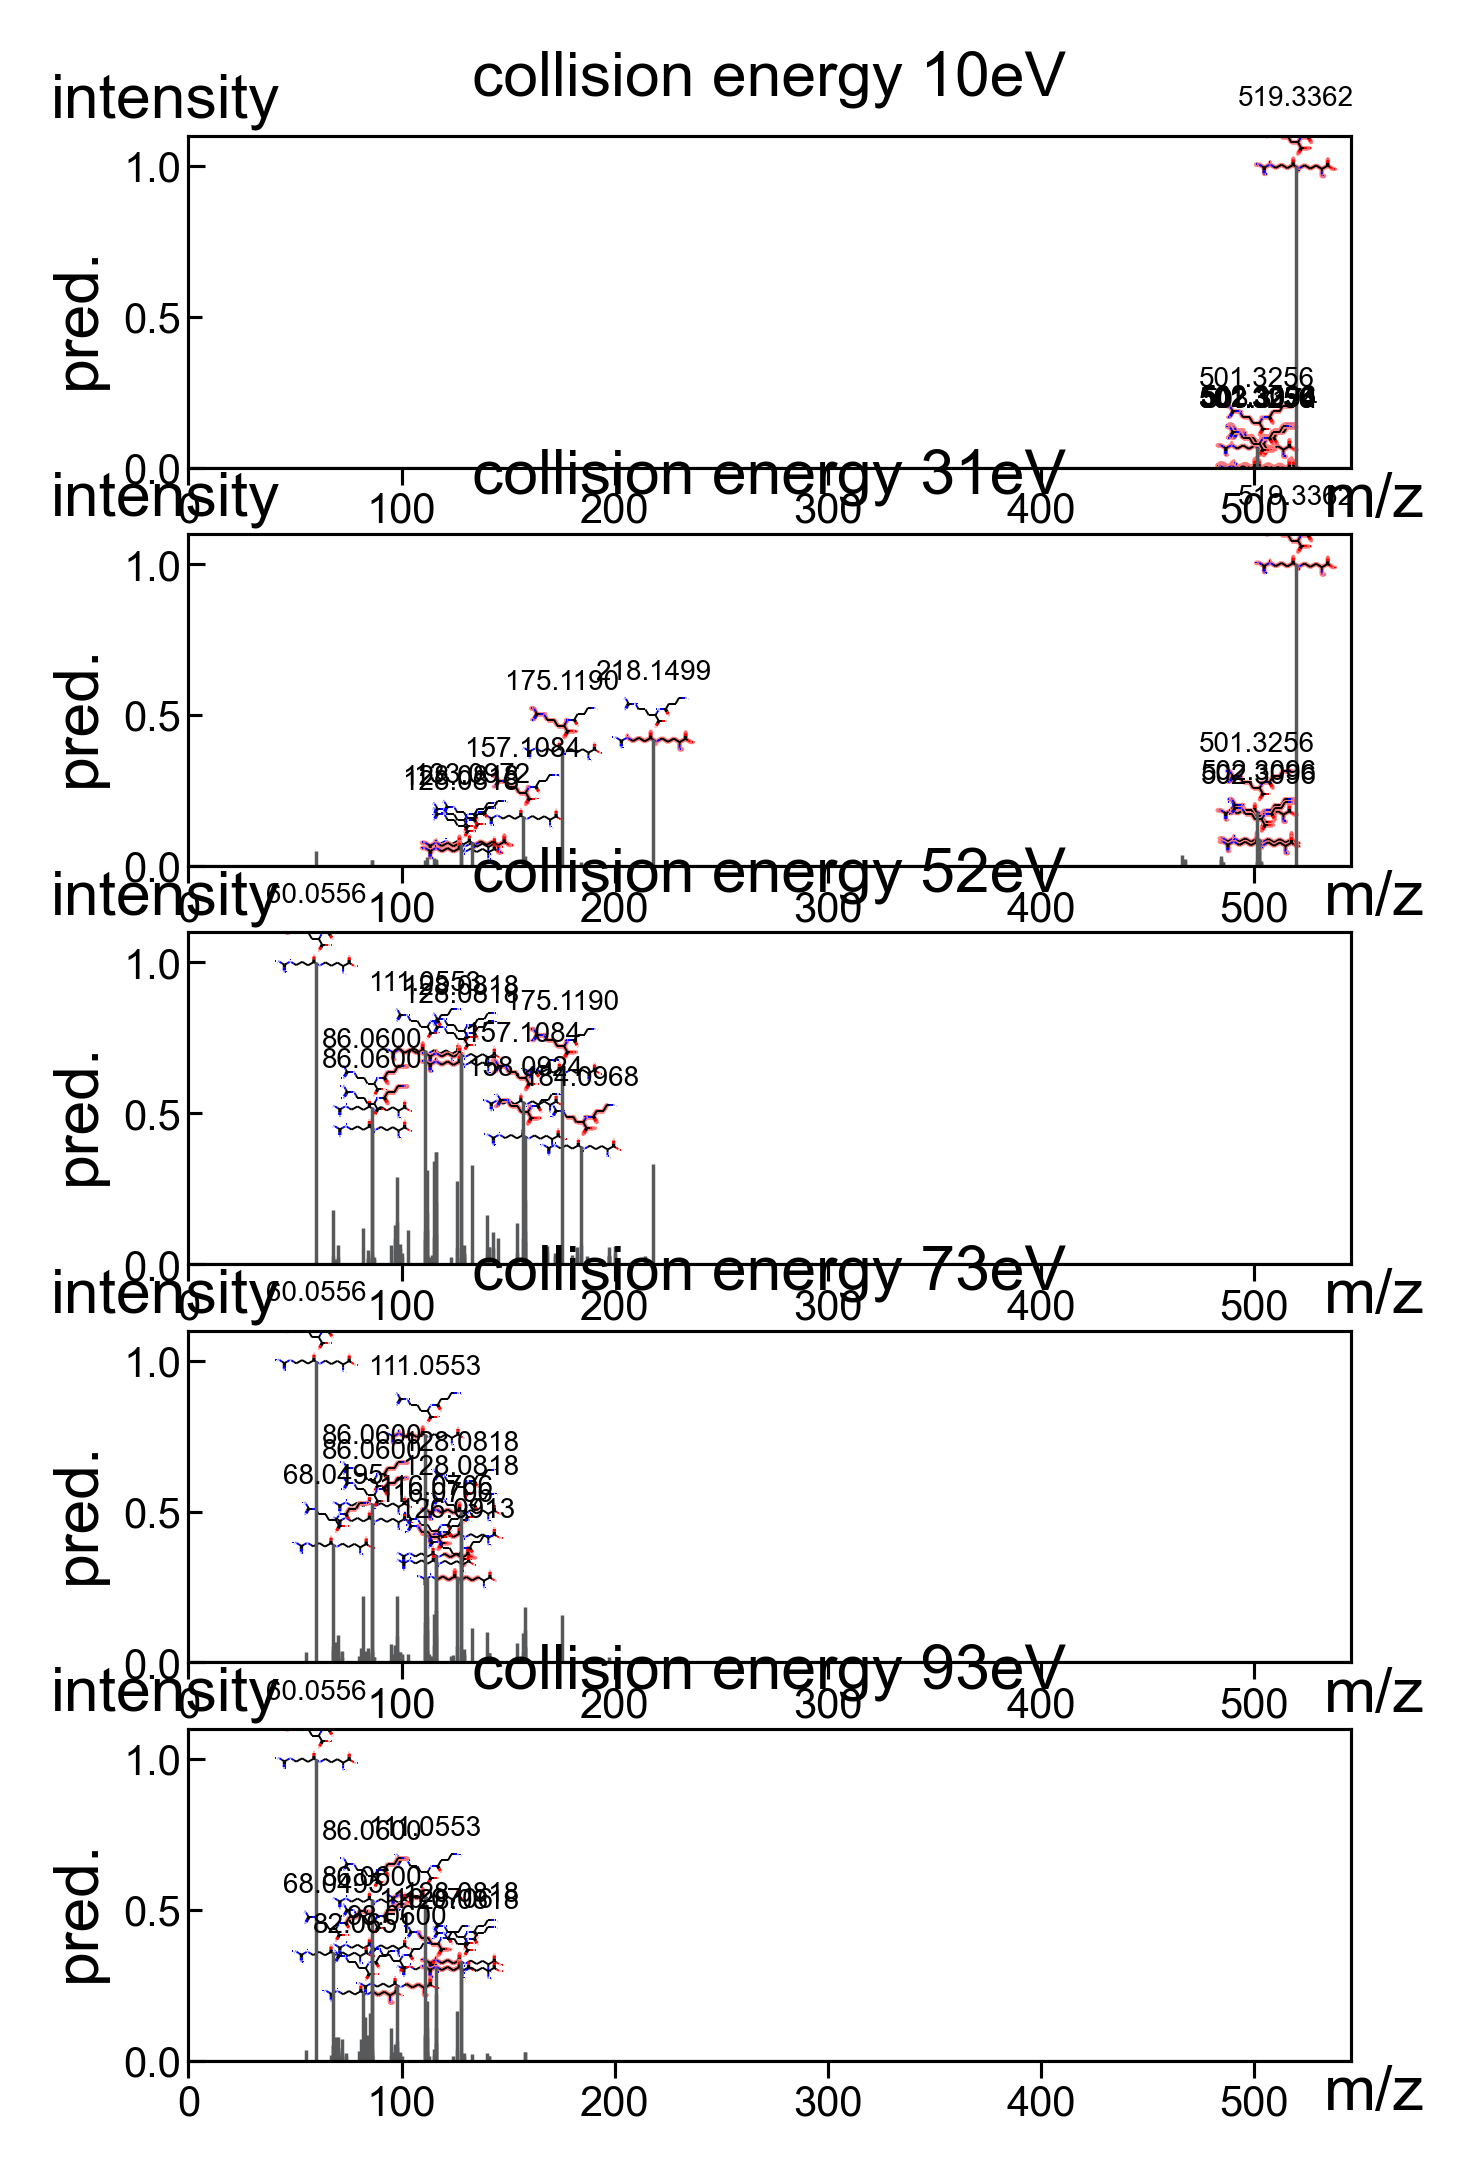

In [20]:
visual_preds(r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N', np.arange(10, 100, 20), nce=True, explain_npeaks=10, name='gaba-arg')

In [8]:
# Show peak predictions + experiment spectrum matching
def visual_preds_compare(pred_smi, exp_spec_path, colli_energies=[10, 20, 30, 40, 50], nce=False, merge_ces=False, explain_npeaks=0, name="", real_spec_type='ms', axes=None, **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = nce  # use nce for collision energy
    _config['merge_spec'] = merge_ces # merge spec for visualization
    for k, v in kwargs.items():
        _config[k] = v

    # Get candidates
    smiles = [pred_smi]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, colli_energies, **_config)
    
    topk_results = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, real_spec_type=real_spec_type, step_collision_energy=merge_ces, **_config)
    entropy_dist = topk_results[0][1]

    # Visualize and explain peaks
    if axes is None:
        if merge_ces:
            fig = plt.figure(figsize=(3, 2.), dpi=500)
            axes = plt.gca()
        else:
            fig, axes = plt.subplots(len(colli_energies), 1, figsize=(3, 2. * len(colli_energies)), dpi=500)
    explain_peaks(result_path, exp_spec_path, pmz, pred_smi, num_peaks=explain_npeaks, axes=axes, pmz=pmz, real_spec_type=real_spec_type, display_expmass=False, save_path=f'{name}.pdf' if len(name) > 0 else None, **_config)
    if merge_ces:
        axes.text(pmz/15, -1, f'S={1-entropy_dist:.2f}')

# Fig 3 GABA-Arg

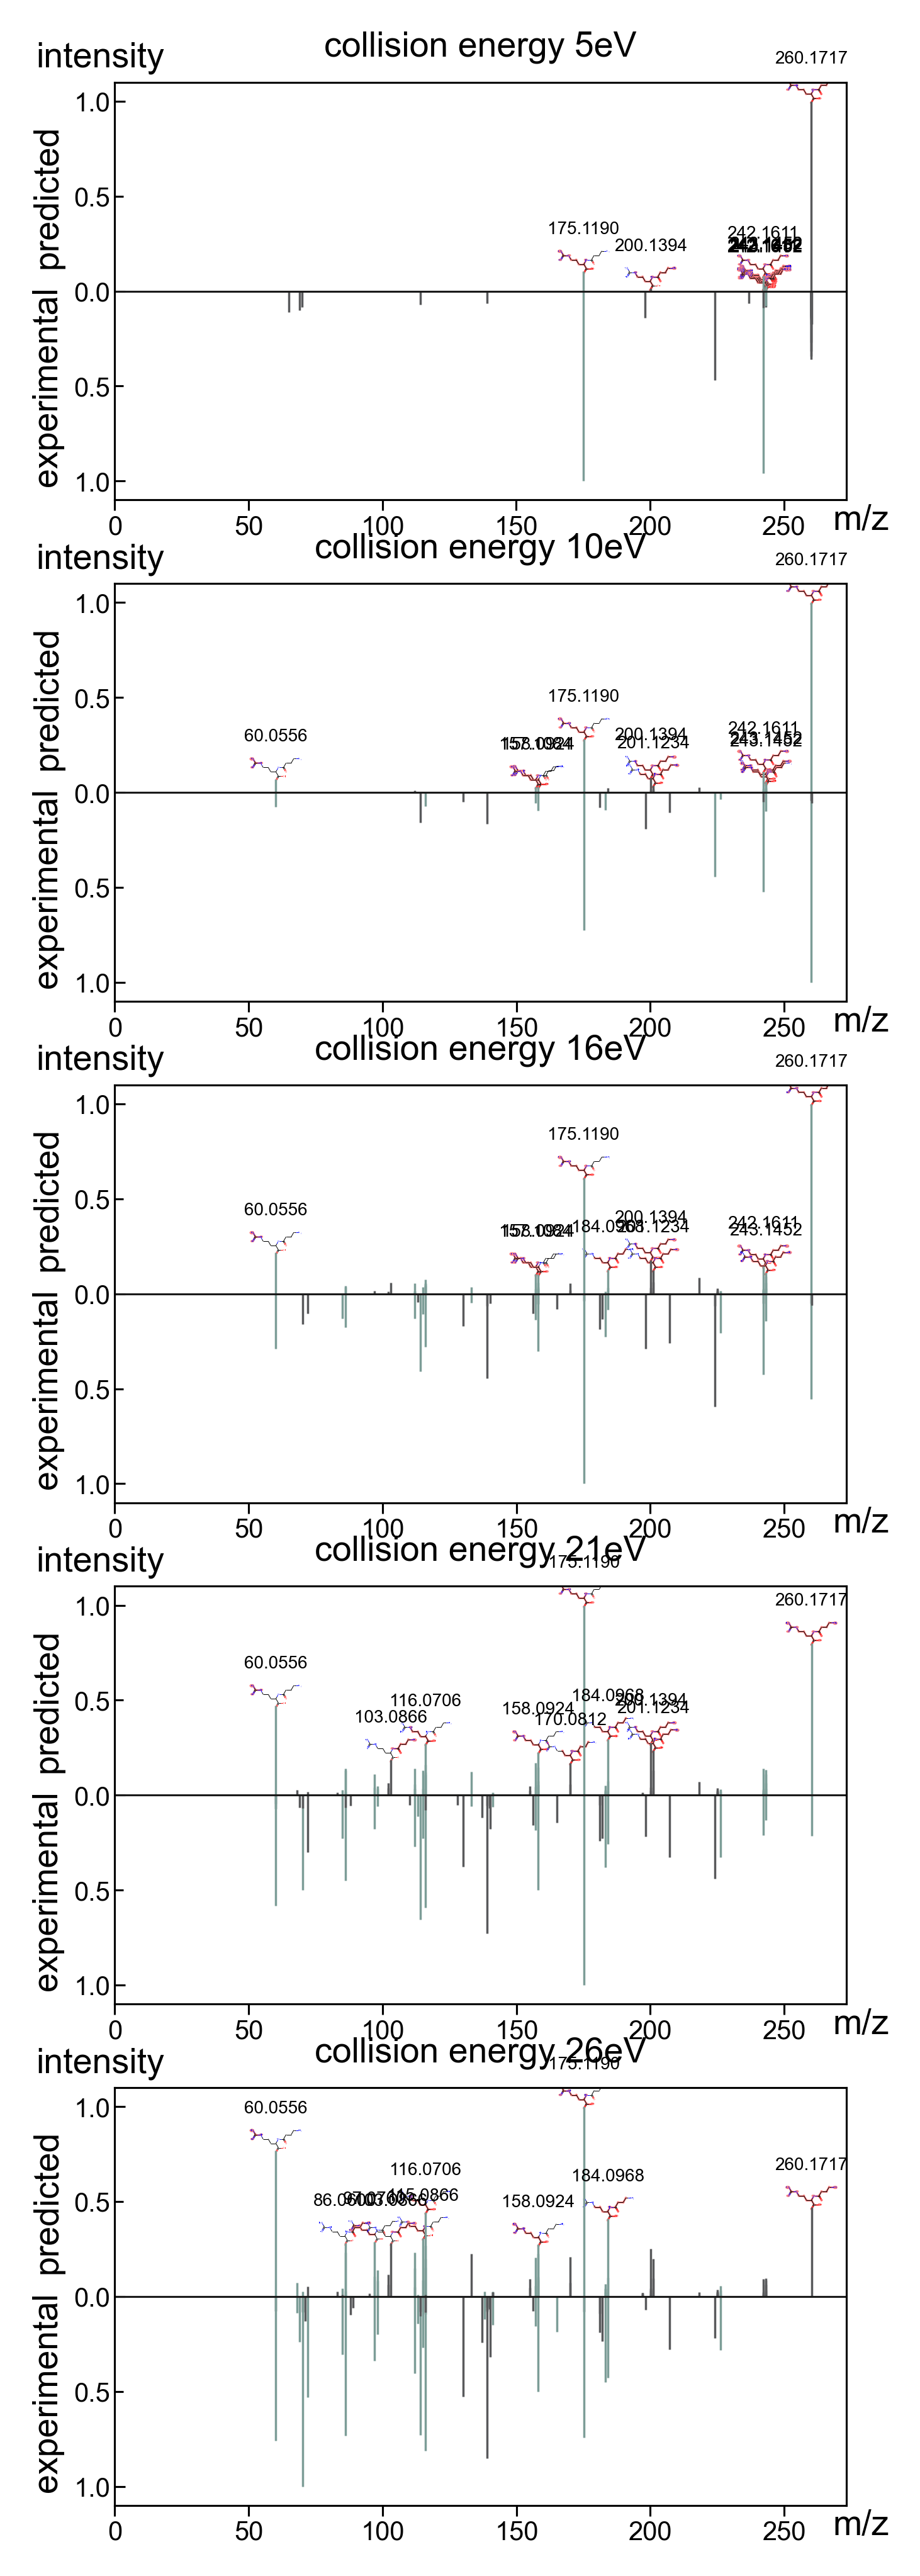

In [8]:
visual_preds_compare(r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N',
                     f'/home/roger/ms_collaborators/broad-Julian/spec_files/mxp4308.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=10, name='gaba-arg')

# Fig 3 LPC 19:0

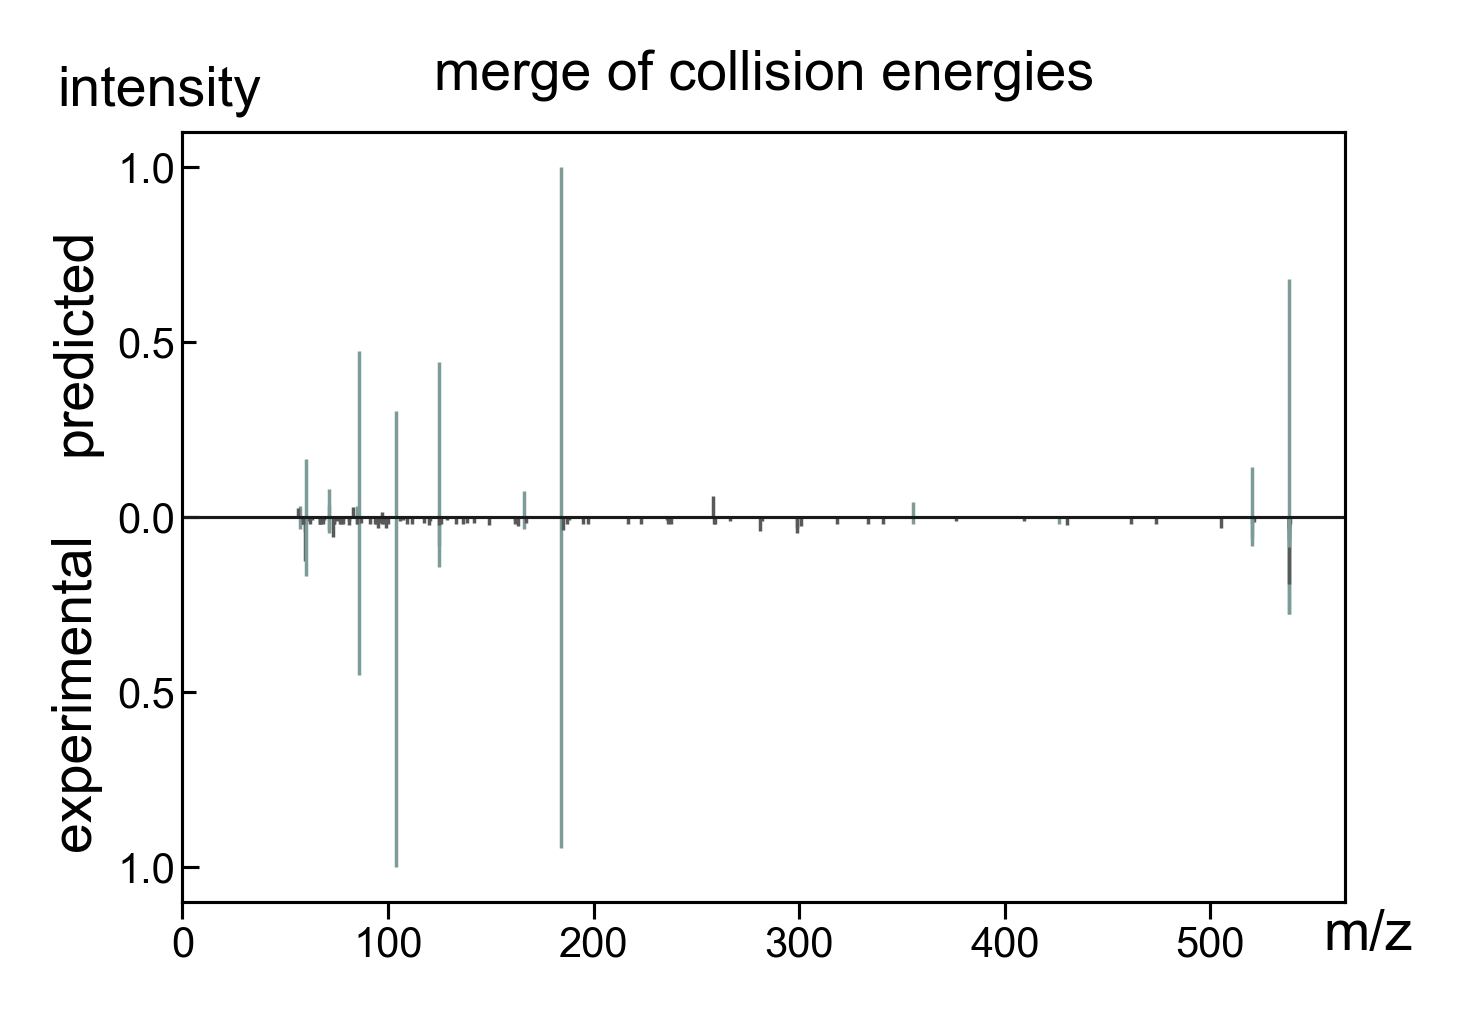

In [9]:
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)CC(OCCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'/home/roger/ms_collaborators/broad-Julian/spec_files/QI8894.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='lpc-19-0-1')
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)COC(CCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'/home/roger/ms_collaborators/broad-Julian/spec_files/QI8894.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='lpc-19-0-2')
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)COC(CCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'/home/roger/ms_collaborators/broad-Julian/spec_files/QI8894.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='lpc-19-0-2')

# Fig 3 Hercynine
separated collision energies

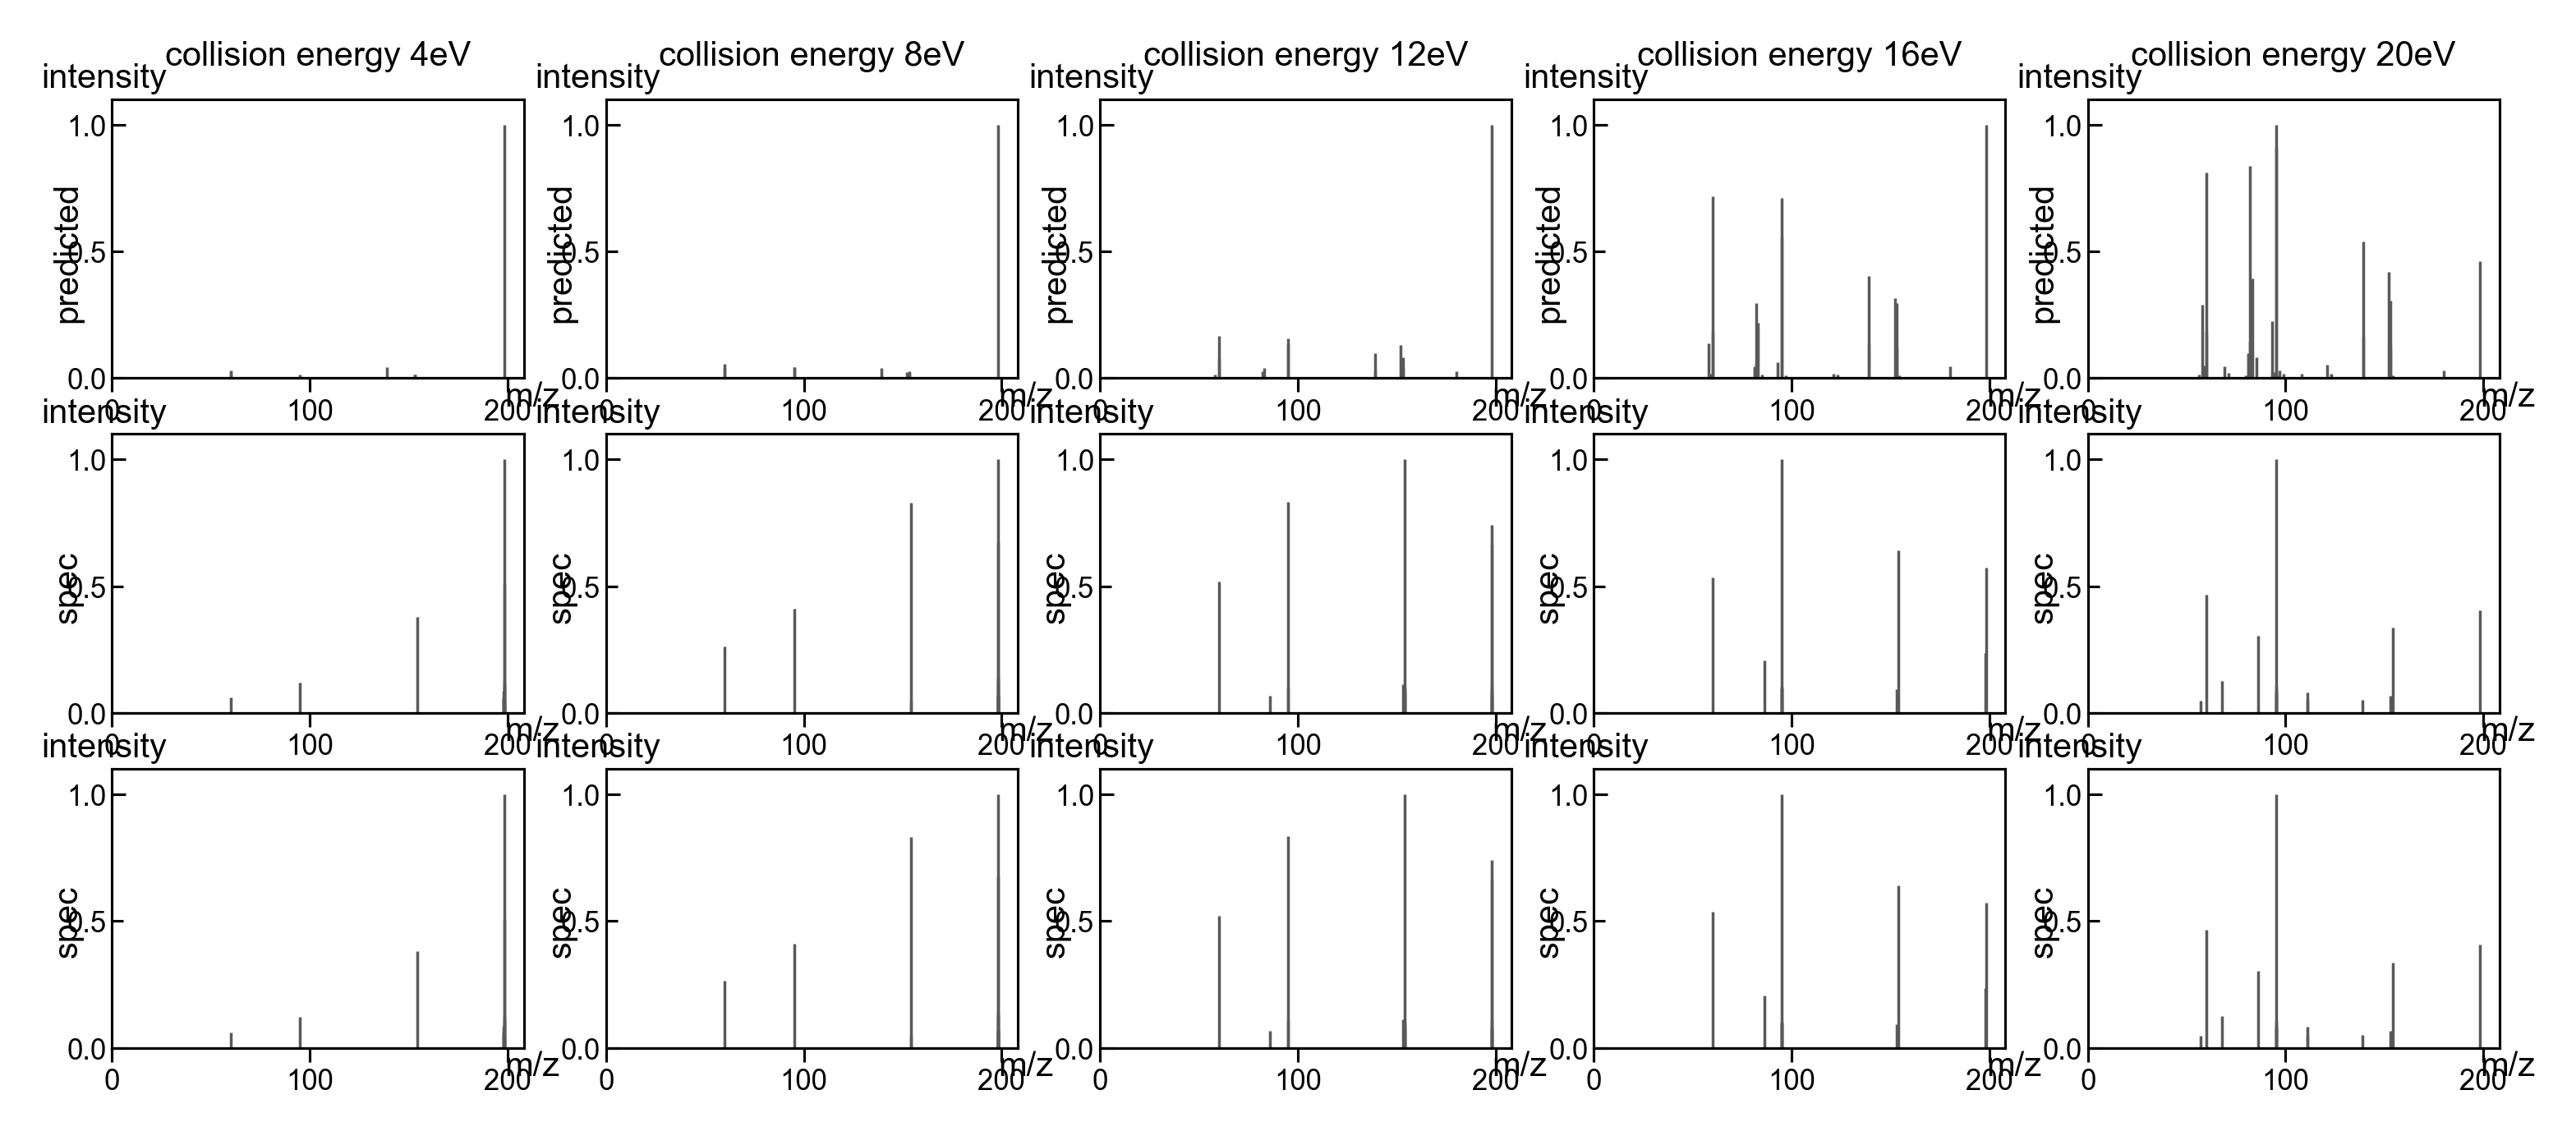

In [5]:
_config = copy.deepcopy(config)
_config['nce'] = True  # use nce for collision energy
_config['merge_spec'] = False # merge spec for visualization
colli_energies = np.arange(10, 51, 10)
smiles = r'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]'

fig, axes = plt.subplots(3, len(colli_energies), figsize=(1.5 * len(colli_energies), 1. * 3), dpi=500)

# Run ICEBERG to predict spectra
result_path, pmz = iceberg_prediction([smiles], colli_energies, **_config)

# visualize prediction
_ = explain_peaks(result_path, None, pmz, smiles, num_peaks=0, axes=axes[0], **_config)

# [TODO: Should be] standard MS/MS
standard_spec = load_real_spec('/home/roger/ms_collaborators/broad-Julian/spec_files/QI7142.ms', 'ms', nce=True)
for nce, ax in zip(colli_energies, axes[1]):
    ev_key = common.nce_to_ev(str(nce.item()), pmz)
    common.plot_ms(standard_spec[ev_key], ax=ax)

# detected MS/MS feature
feature_spec = load_real_spec('/home/roger/ms_collaborators/broad-Julian/spec_files/QI7142.ms', 'ms', nce=True)
for nce, ax in zip(colli_energies, axes[2]):
    ev_key = common.nce_to_ev(str(nce.item()), pmz)
    common.plot_ms(feature_spec[ev_key], ax=ax)

plt.savefig('hercynine.pdf', bbox_inches='tight')

# Fig 3 Thiophanate-methyl TP

2252it [00:00, 28355.89it/s]


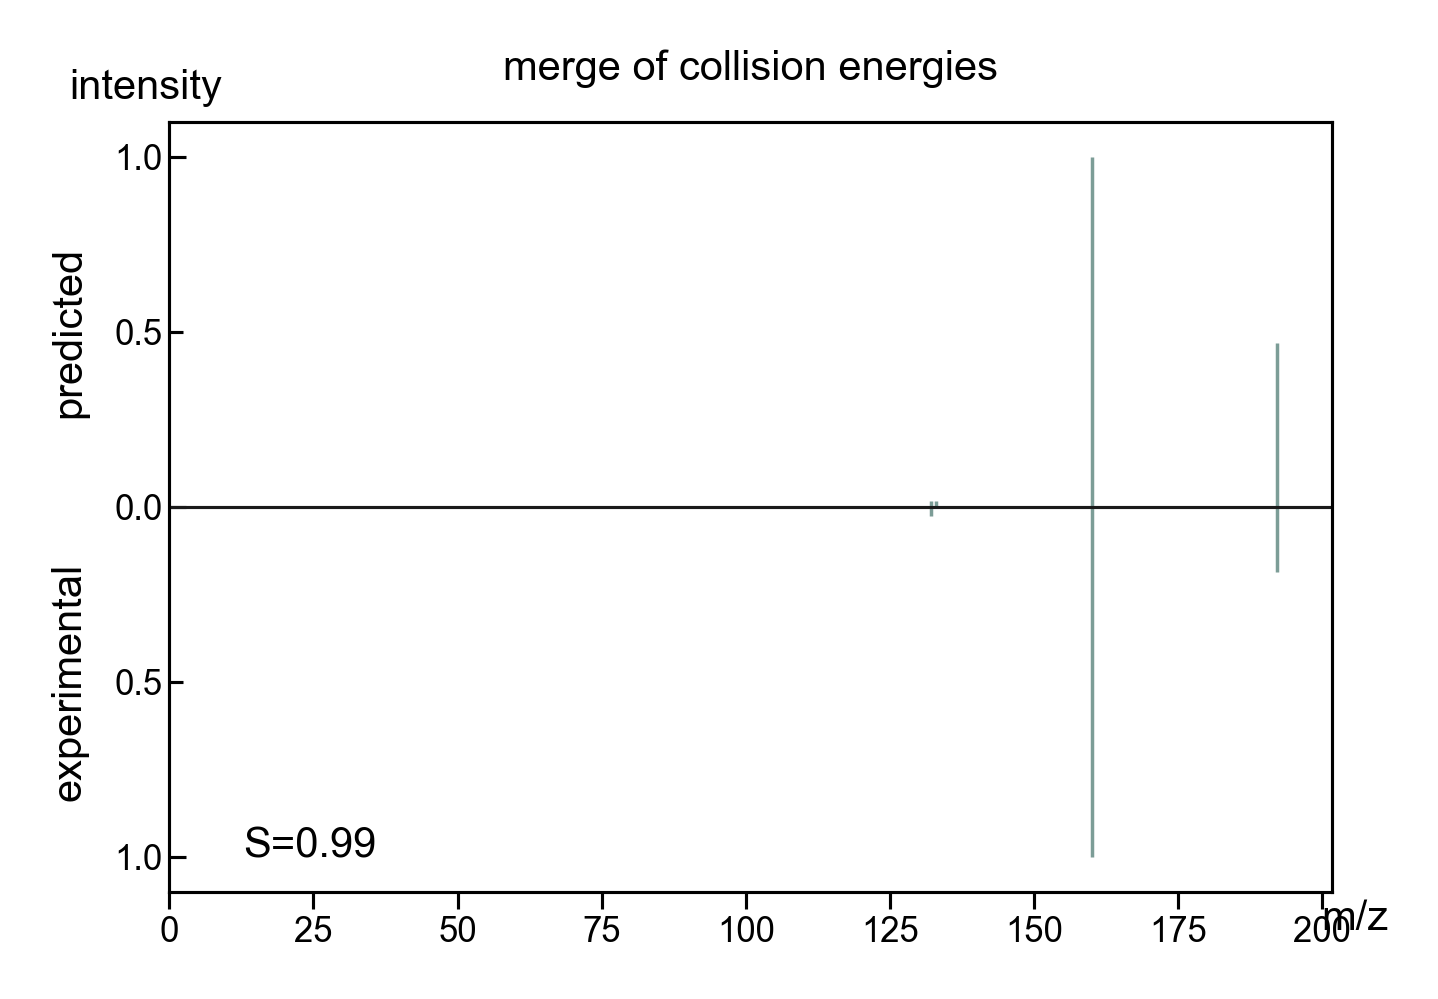

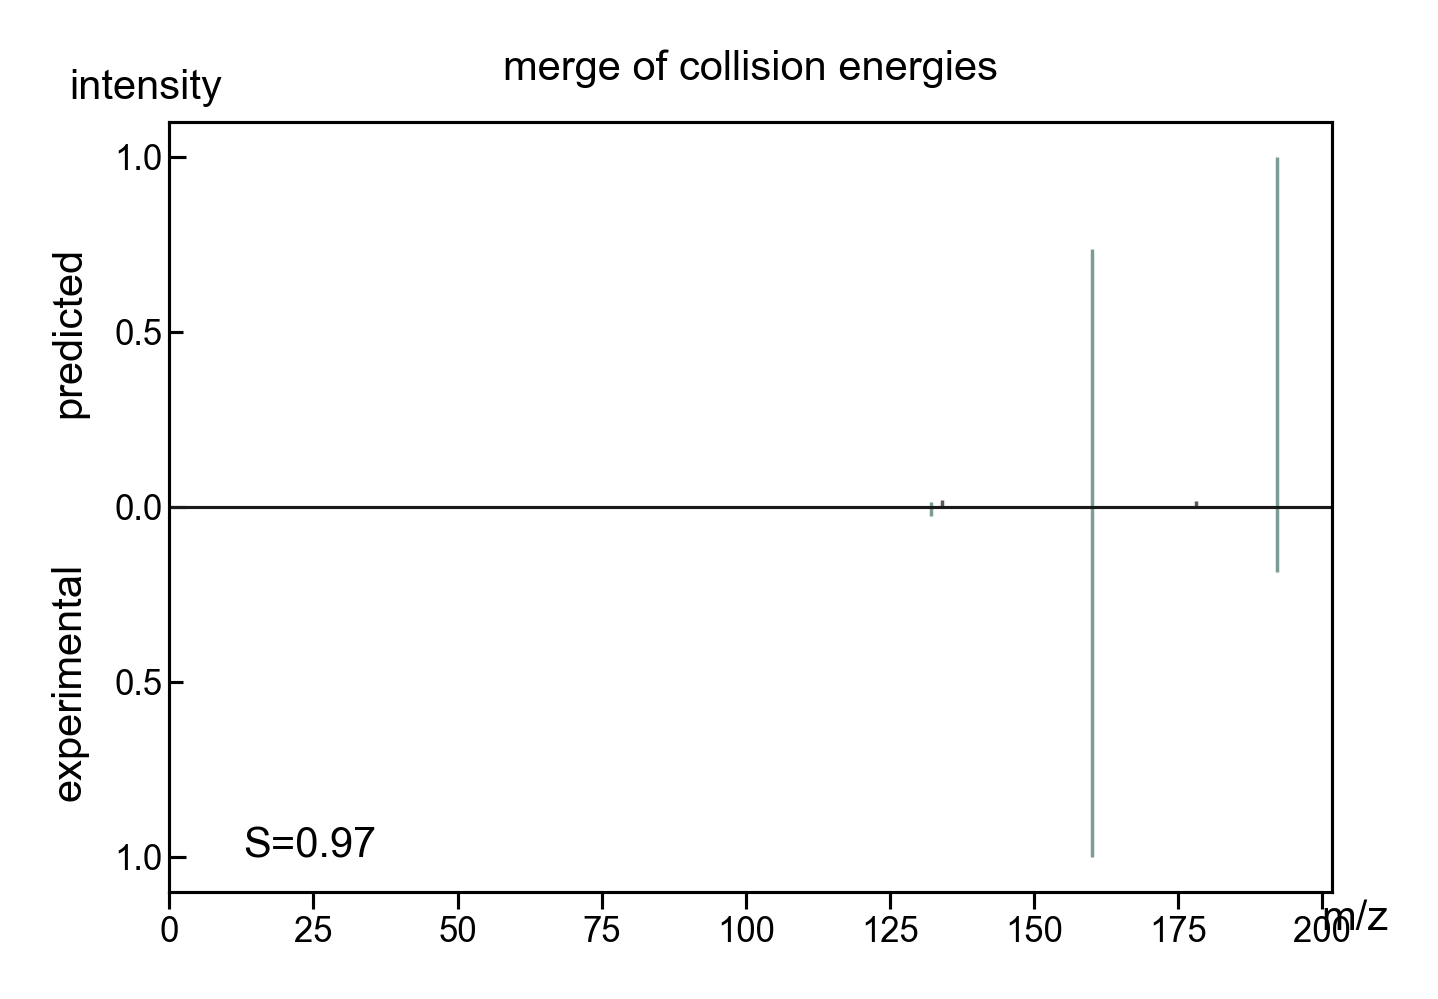

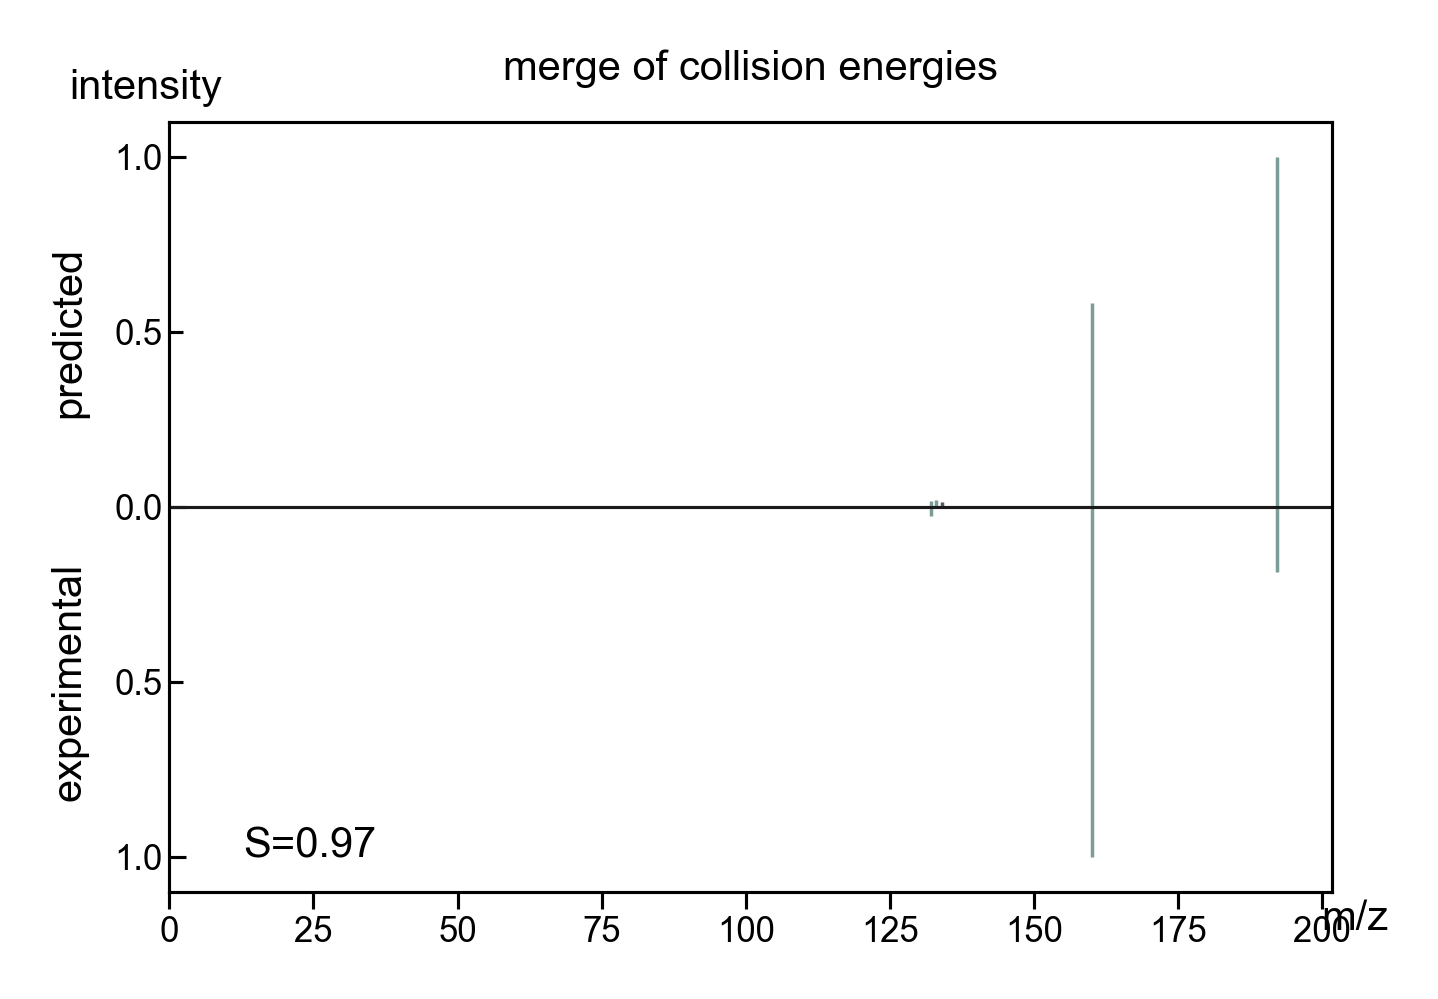

In [10]:
inp_mgf = '/home/roger/ms_collaborators/Joules-Pesticide/sirius_no_int_std.mgf'

all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and entry[0]['FEATURE_ID'] == '919')
    # 919 is the feature_id of interst
}
spec = {'nan': feat_id_to_specs['919']}

visual_preds_compare(r'COC(=O)N=c1[nH]c2ccccc2[nH]1', spec,
                     [30, 45, 60], nce=True, merge_ces=True, explain_npeaks=0, real_spec_type='raw', name='th-tp-1')

visual_preds_compare(r'COC(=O)Nc1cn2ccccc2n1', spec,
                     [30, 45, 60], nce=True, merge_ces=True, explain_npeaks=0, real_spec_type='raw', name='th-tp-2')

visual_preds_compare(r'COC(=O)Nc1ccn2ccnc2c1', spec,
                     [30, 45, 60], nce=True, merge_ces=True, explain_npeaks=0, real_spec_type='raw', name='th-tp-3')

# Fig 4 Buchwald–Hartwig pooled reaction

In [70]:
import itertools

all_smiles = ['C%12(CCCNC%13=CC=CC=C%13)=CC=CC=C%12', 'CCC(NC6=CC=CC=C6)C7=CC=CC=C7', 'CC(C)C%10=C(NC%11=CC=CC=C%11)C=CC=C%10', 'CCC8=CC=CC(C)=C8NC9=CC=CC=C9']
# all_feat_ids = ['3734', '5249', '5474', '6060']
# inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250221_cn_pool/cn_pool_latest_20250221.mgf'
# all_feat_ids = ['4698', '6796', '7130', '7977']
# inp_mgf = '/home/runzhong/ms_collaborators/bo_reaction/all_nitro_and_iodo_20250404_iimn_fbmn.mgf'
all_feat_ids = ['5878', '9622', '11980', '8512']
inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250405_pool/all_nitro_and_iodo_20250411_sirius.mgf'

all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and entry[0]['FEATURE_ID'] in all_feat_ids)
}
# all_specs = [feat_id_to_specs[id] for id in all_feat_ids]
#
#
# fig, axes = plt.subplots(len(all_smiles), len(all_feat_ids), figsize=(1.5 * len(all_feat_ids), 1 * len(all_smiles)), dpi=500)
# for i, j in itertools.product(range(len(all_smiles)), range(len(all_feat_ids))):
#     ax = axes[i][j]
#     visual_preds_compare(all_smiles[i], {'nan': all_specs[j]}, [30, 45, 60],
#                          nce=True, explain_npeaks=0, merge_ces=True, real_spec_type='raw', axes=ax, ignore_precursor=False)
#     ax.set_title("")
#     if j != len(all_smiles) - 1:
#         ax.set_xlabel("")
#     if i != 0:
#         ax.set_ylabel("")
# plt.savefig('bh_pool.pdf', bbox_inches='tight')

28076it [00:01, 26838.19it/s]


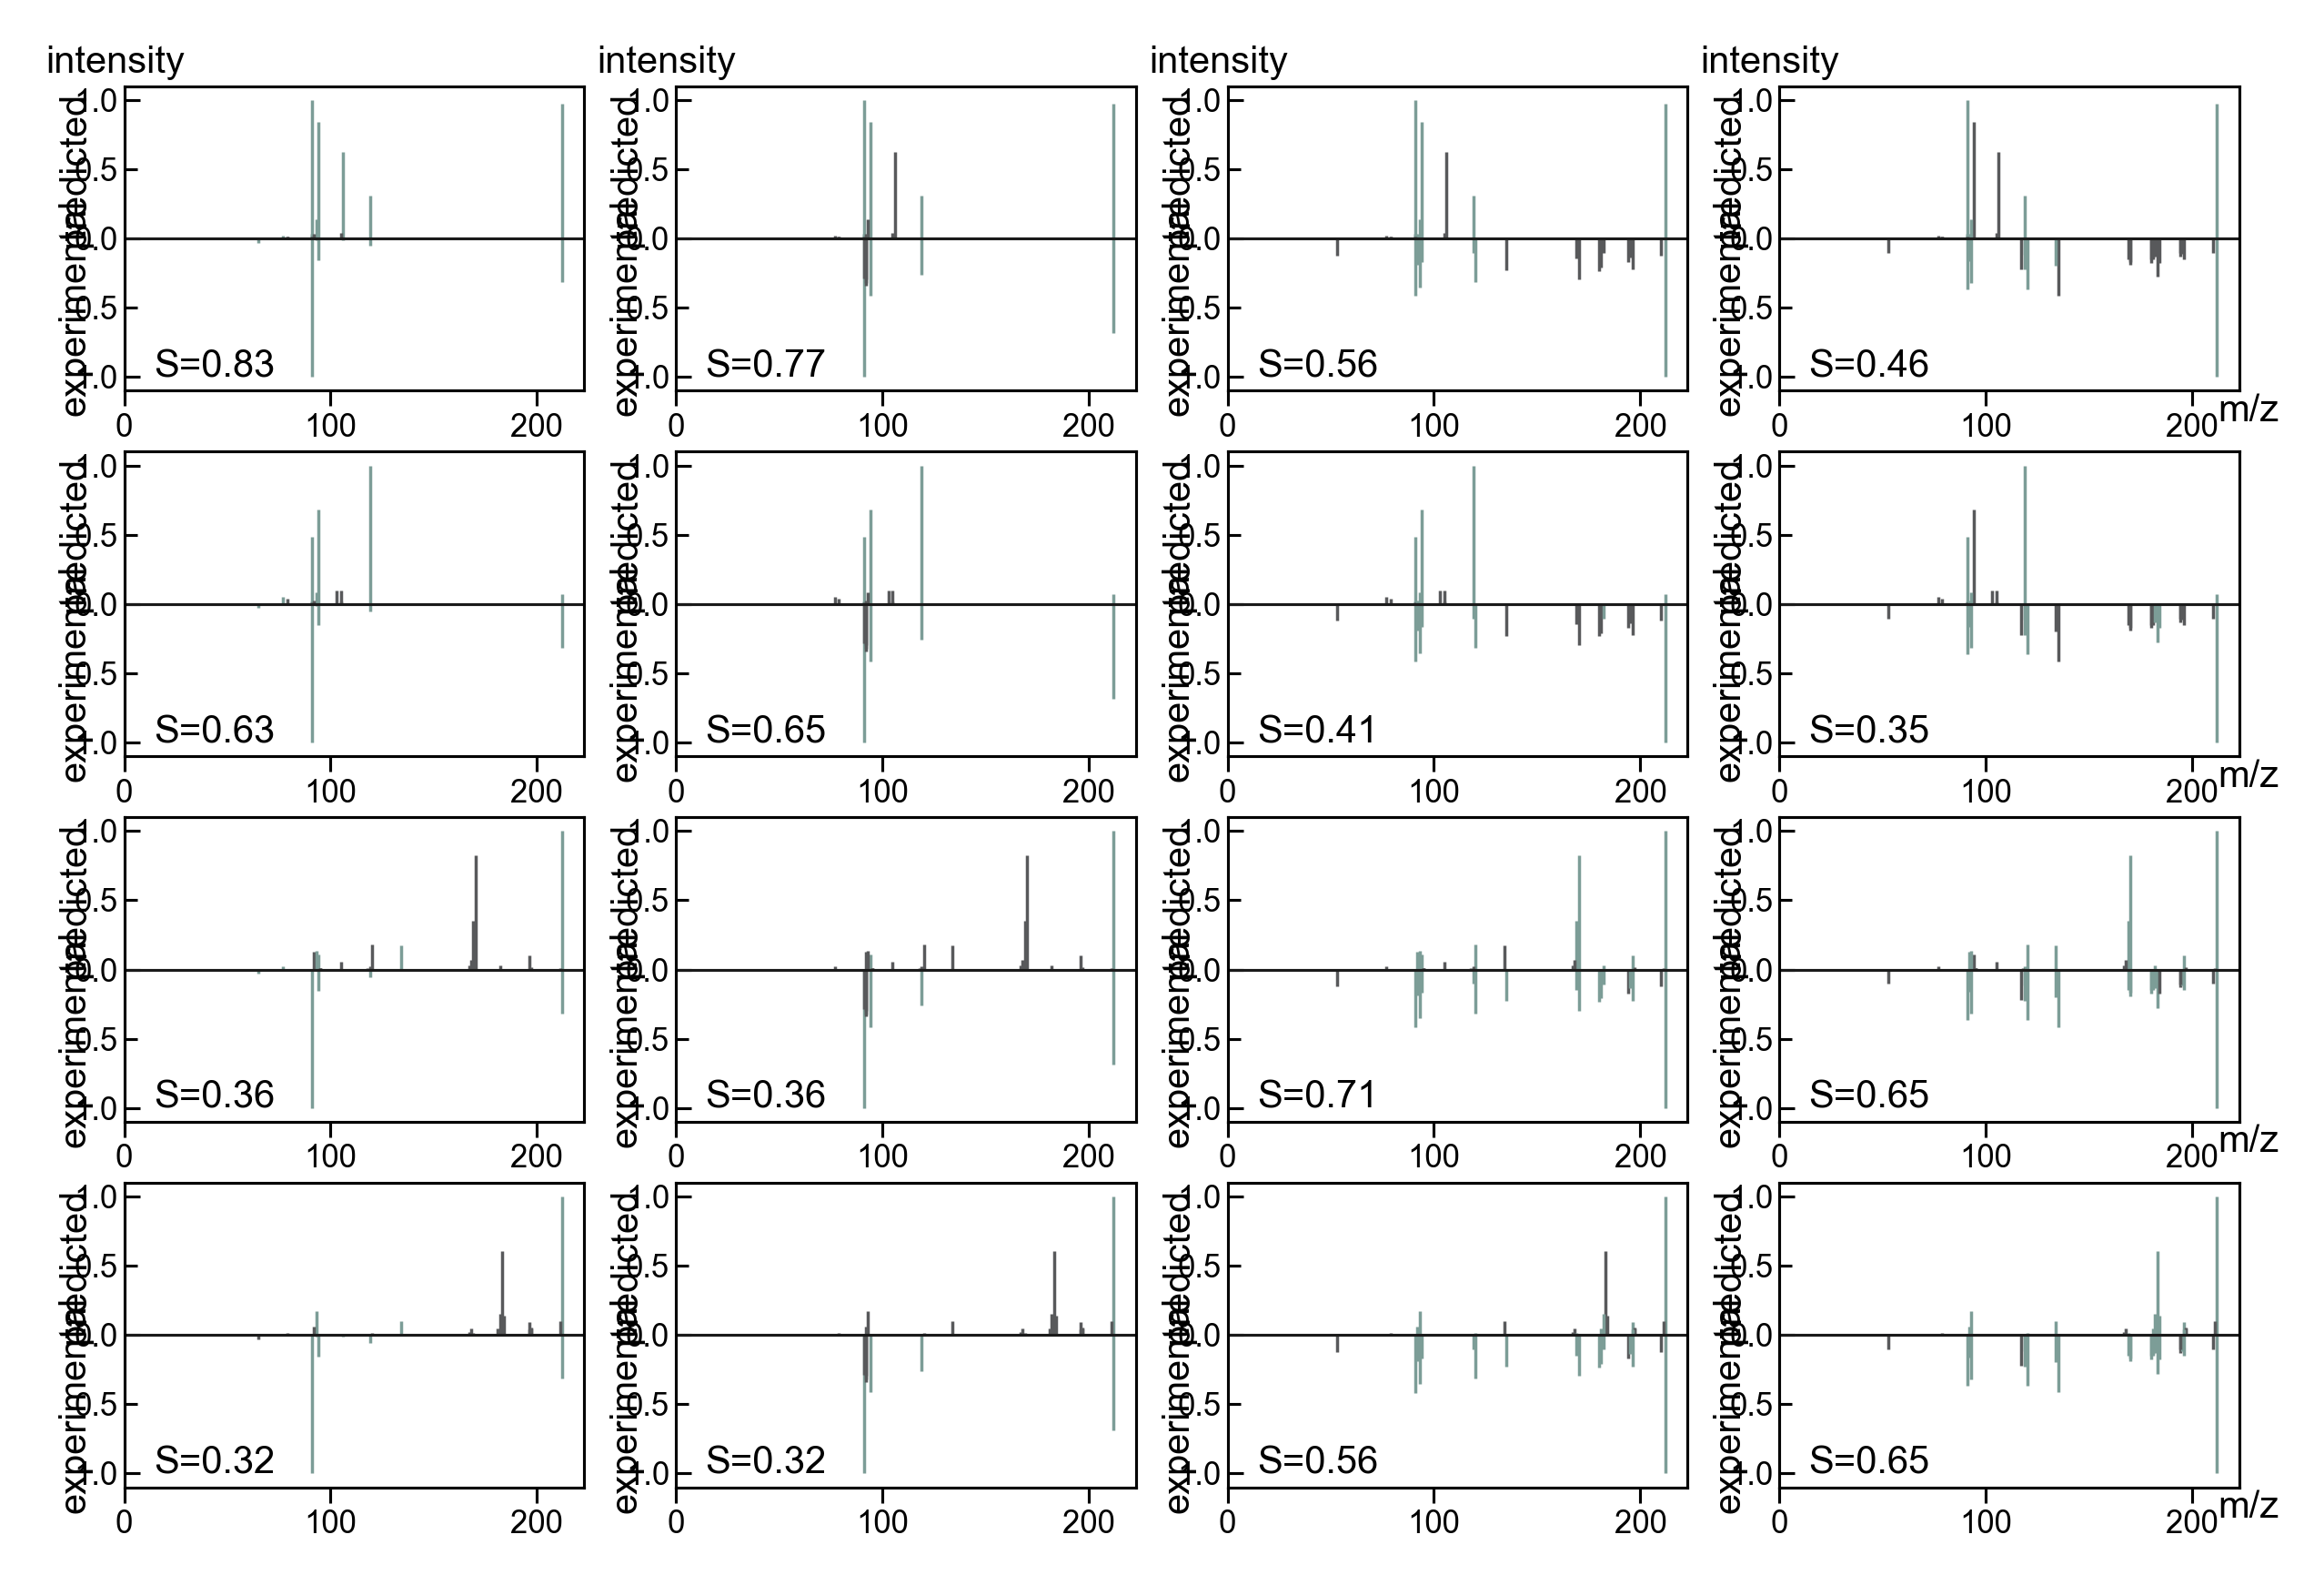

In [71]:
# manually merge specs, the following scans are obtained by manually parsing the raw data

all_mzs = [
    [91.0544, 91.9061, 91.9082, 100.9753, 115.4284, 129.7684, 204.3770, 212.1438],
    [70.2320, 91.0543, 91.9053, 91.9083, 125.3397,
        128.5127, 129.6969, 188.6784, 188.7928, 212.1440],
    [62.8332, 91.0543, 221.2854],
    [91.0544, 94.0652, 101.5873, 106.8550, 114.1071,
        139.5107, 145.0307, 212.1441, 230.8916, 234.3647],
    [81.7754, 91.0544, 91.0571, 91.9074, 94.0652, 102.3442, 119.0858, 212.1435]]
all_intens = [
    [1.8E6, 2.5E5, 2.7E5, 1.9E5, 1.9E5, 1.9E5, 2.0E5, 5.2E5],
    [2.0E5, 7.0E5, 4.3E5, 5.7E5, 1.9E5, 2.1E5, 2.0E5, 2.0E5, 2.2E5, 2.1E5],
    [2.4E5, 7.4E5, 2.8E5],
    [2.2E6, 4.5E5, 2.0E5, 1.9E5, 1.9E5, 2.0E5, 2.0E5, 1.0E6, 2.1E5, 1.9E5],
    [2.0E5, 4.9E6, 4.0E5, 5.1E5, 8.4E5, 2.1E5, 3.3E5, 2.3E6]
]

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(0, 5)]
# spec_9622 = common.merge_specs(all_peaks, merge_method='max')['nan']
spec_9622 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_9622 = common.max_inten_spec(spec_9622, inten_thresh=0.25)

all_mzs = [
[65.0387,74.6598,91.0543,91.9062,92.0495,93.0574,94.0652,101.0682,101.5591,106.0652,106.8943,109.4952,113.1854,117.7091,119.0855,120.0808,126.3508,135.1041,160.8612,169.0889,170.0965,180.0809,181.0886,194.0963,195.1040,196.1122,200.5151,212.1434],
[51.1133,51.7257,52.2547,53.0351,54.8757,56.2296,57.4192,57.7760,58.4713,58.6909,58.8861,62.1809,65.0386,67.2169,67.9829,78.7928,80.8177,83.7624,91.0543,91.9073,92.0496,93.0543,93.0574,94.0653,103.0545,106.0652,120.0809,120.0855,131.0731,134.0964,135.1042,150.6048,153.0700,155.4503,167.0737,168.0809,169.0885,170.0964,171.3577,180.0808,181.0886,182.0968,193.9541,194.0965,195.1044,196.1121,197.1199,208.6856,210.1277,212.1434,212.1643],
[51.0232,53.0350,65.0385,70.5860,72.6995,79.0542,82.9689,89.3041,91.0513,91.0543,91.9061,91.9091,92.0495,93.0573,94.0650,106.0650,120.0761,120.0808,134.0963,135.1042,137.9546,145.5597,149.8257,153.0697,168.0804,168.3178,169.0885,170.0963,180.0808,181.0885,182.0966,191.0895,194.0962,195.1043,196.1121,197.1197,210.1275,212.1433,212.6767],
[53.0351,54.5088,65.0387,91.0543,91.9076,92.0467,92.0496,93.0543,93.0574,94.0651,95.2928,106.0651,120.0809,123.1999,134.0965,135.1043,136.7619,137.9254,143.0854,153.0695,157.7873,168.0806,169.0888,170.0964,180.0808,181.0888,182.0966,194.0966,195.1045,196.1121,197.1207,210.1278,212.1320,212.1434],
[53.0351,65.0385,91.0543,91.9053,91.9083,92.0496,93.0574,94.0651,103.0545,106.0651,119.0857,120.0809,127.7293,131.0731,134.0965,135.1042,153.0697,165.4003,168.0809,169.0886,170.0964,180.0807,181.0886,182.0964,183.1041,194.0966,195.1044,196.1121,197.1197,210.1282,212.1434],
[53.0350,67.9866,71.9841,89.5372,91.0517,91.0544,92.0495,93.0574,103.0545,117.0698,117.3706,119.0855,120.0808,124.9924,134.0964,135.1042,137.3235,140.1042,168.0809,169.0887,170.0962,180.0808,181.0882,182.0966,183.1040,184.1120,194.0964,195.1041,196.1120,210.1279,212.1320,212.1434],
[53.0350,65.0386,79.0542,91.0543,91.9057,91.9085,92.0496,93.0574,93.0602,93.0698,103.0541,110.2593,117.0699,119.0731,119.0856,120.0808,123.5046,134.0963,135.1042,135.1097,169.0884,170.0965,178.9617,180.0807,181.0885,182.0964,183.1043,184.1120,194.0967,195.1043,196.1120,204.8851,210.1272,210.9980,212.1433,233.7700],
[53.0351,65.0385,67.1078,79.0543,91.0543,91.9066,92.0495,93.0547,93.0574,103.0542,104.0620,104.6086,106.0651,115.0541,117.0699,119.0729,119.0856,120.0808,120.0855,126.9029,134.0965,135.1042,142.2281,142.2337,169.0884,170.0966,180.0806,181.0886,182.0964,183.1043,184.1123,194.0964,195.1041,196.1122,197.1203,207.8730,210.1278,212.1433,227.9024],
[53.0351,53.4538,59.8154,65.0386,79.0543,85.1691,91.0543,91.9078,92.0495,92.8562,93.0574,93.0699,98.6425,103.0542,106.0651,115.0541,117.0699,119.0729,119.0856,119.5667,120.0808,120.5405,121.6822,134.0965,135.1042,135.1097,139.9886,153.8650,168.0813,169.0882,170.0965,178.4134,180.0805,181.0884,182.0965,183.1042,184.1123,194.0969,195.1043,196.1122,197.1201,198.8276,210.1277,212.1433]]
all_intens = [
[2.2E5,1.8E5,1.3E7,4.9E5,5.9E5,2.0E6,2.1E6,1.9E5,2.1E5,3.1E5,1.9E5,1.9E5,2.3E5,1.8E5,8.0E5,1.6E6,1.9E5,9.7E5,2.1E5,2.5E5,1.5E6,7.8E5,6.8E5,6.5E5,4.0E5,8.2E5,2.0E5,1.8E7],
[1.7E5,1.8E5,1.6E5,1.1E6,1.8E5,1.6E5,1.8E5,1.5E5,1.6E5,1.8E5,1.5E5,1.8E5,4.8E5,1.7E5,2.0E5,1.9E5,2.0E5,2.0E5,8.6E6,3.0E5,2.7E6,3.9E5,9.4E6,5.6E5,2.4E5,7.1E5,7.5E6,2.5E5,2.0E5,3.9E5,3.9E6,2.2E5,5.2E5,2.1E5,2.5E5,5.9E5,1.6E6,6.6E6,2.1E5,4.1E6,3.3E6,8.4E5,2.1E5,2.2E6,1.4E6,3.8E6,3.1E5,2.2E5,1.1E6,7.5E7,4.6E5],
[2.2E5,5.9E5,4.1E5,2.1E5,2.1E5,2.0E5,1.9E5,1.9E5,3.5E5,7.5E6,5.1E5,3.0E5,2.6E6,7.3E6,2.9E5,6.3E5,2.2E5,6.4E6,6.3E5,3.0E6,2.3E5,1.9E5,2.1E5,5.9E5,5.6E5,2.2E5,9.7E5,5.8E6,3.0E6,2.4E6,5.9E5,2.1E5,2.3E6,9.8E5,2.7E6,3.1E5,9.7E5,4.9E7,2.1E5],
[6.1E5,2.1E5,4.1E5,6.8E6,3.4E5,2.5E5,3.2E6,2.7E5,8.1E6,4.2E5,2.1E5,5.3E5,6.1E6,2.3E5,2.9E5,3.2E6,2.1E5,2.3E5,2.6E5,5.0E5,2.1E5,5.1E5,1.2E6,6.5E6,3.9E6,2.5E6,7.4E5,2.2E6,1.4E6,3.1E6,2.3E5,6.7E5,4.8E5,5.0E7],
[5.5E5,5.4E5,7.3E6,4.3E5,5.2E5,2.6E6,7.7E6,3.6E5,2.3E5,8.3E5,2.2E5,6.4E6,2.3E5,2.3E5,4.3E5,3.8E6,2.6E5,2.2E5,5.7E5,1.6E6,5.3E6,3.8E6,2.9E6,8.9E5,2.5E5,2.2E6,1.3E6,3.2E6,3.2E5,1.1E6,4.6E7],
[3.2E5,2.0E5,2.3E5,2.2E5,3.0E5,3.4E6,1.1E6,2.5E6,2.0E5,5.3E5,2.0E5,7.2E5,2.7E6,2.0E5,7.9E5,3.5E6,2.1E5,1.9E5,2.3E5,4.3E5,1.4E6,1.1E6,7.2E5,4.5E5,1.1E6,6.1E5,6.7E5,3.9E5,1.1E6,4.6E5,3.6E5,3.4E7],
[4.5E5,3.3E5,3.7E5,4.9E6,2.8E5,4.6E5,1.3E6,4.5E6,4.2E5,2.4E5,4.7E5,2.2E5,2.1E6,3.7E5,2.0E6,6.0E6,2.3E5,1.7E6,7.7E6,3.6E5,8.2E5,1.4E6,2.3E5,1.6E6,9.7E5,6.8E5,2.6E6,1.0E6,3.1E5,3.2E5,8.7E5,2.3E5,3.3E5,2.2E5,4.4E7,2.2E5],
[5.0E5,3.2E5,2.1E5,3.1E5,5.8E6,3.5E5,1.3E6,2.9E5,3.6E6,3.6E5,3.0E5,2.2E5,3.9E5,4.8E5,2.4E6,5.7E5,2.5E6,6.5E6,2.4E5,2.1E5,1.5E6,8.3E6,2.0E5,2.1E5,1.1E6,1.4E6,1.5E6,9.0E5,8.5E5,3.6E6,1.0E6,8.2E5,2.9E5,8.2E5,2.7E5,2.0E5,4.6E5,4.4E7,2.5E5],
[5.3E5,1.9E5,2.0E5,4.5E5,2.7E5,2.1E5,6.5E6,2.3E5,1.2E6,2.3E5,5.0E6,3.4E5,1.9E5,3.8E5,2.6E5,3.3E5,2.0E6,6.6E5,2.3E6,2.2E5,6.2E6,2.0E5,1.9E5,1.9E6,8.4E6,2.0E5,2.2E5,2.1E5,2.8E5,1.0E6,1.8E6,2.0E5,1.1E6,1.1E6,7.6E5,3.8E6,1.5E6,5.5E5,6.3E5,1.1E6,4.8E5,2.2E5,5.3E5,4.9E7]
]

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(0, 2)]
spec_elute1 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute1 = common.max_inten_spec(spec_elute1, inten_thresh=0.1)

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(7, 9)]
spec_elute2 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute2 = common.max_inten_spec(spec_elute2, inten_thresh=0.1)

all_specs = [feat_id_to_specs['5878'], spec_9622, spec_elute1, spec_elute2]

# plot with fixed MS2
fig, axes = plt.subplots(len(all_smiles), len(all_feat_ids), figsize=(1.5 * len(all_feat_ids), 1 * len(all_smiles)), dpi=500)
for i, j in itertools.product(range(len(all_smiles)), range(len(all_feat_ids))):
    ax = axes[i][j]
    visual_preds_compare(all_smiles[i], {'nan': all_specs[j]}, [30, 45, 60],
                         nce=True, explain_npeaks=0, merge_ces=True, real_spec_type='raw', axes=ax, ignore_precursor=False)
    ax.set_title("")
    if j != len(all_smiles) - 1:
        ax.set_xlabel("")
    if i != 0:
        ax.set_ylabel("")
plt.savefig('bh_pool-iodo.pdf', bbox_inches='tight')

28076it [00:00, 32193.89it/s]


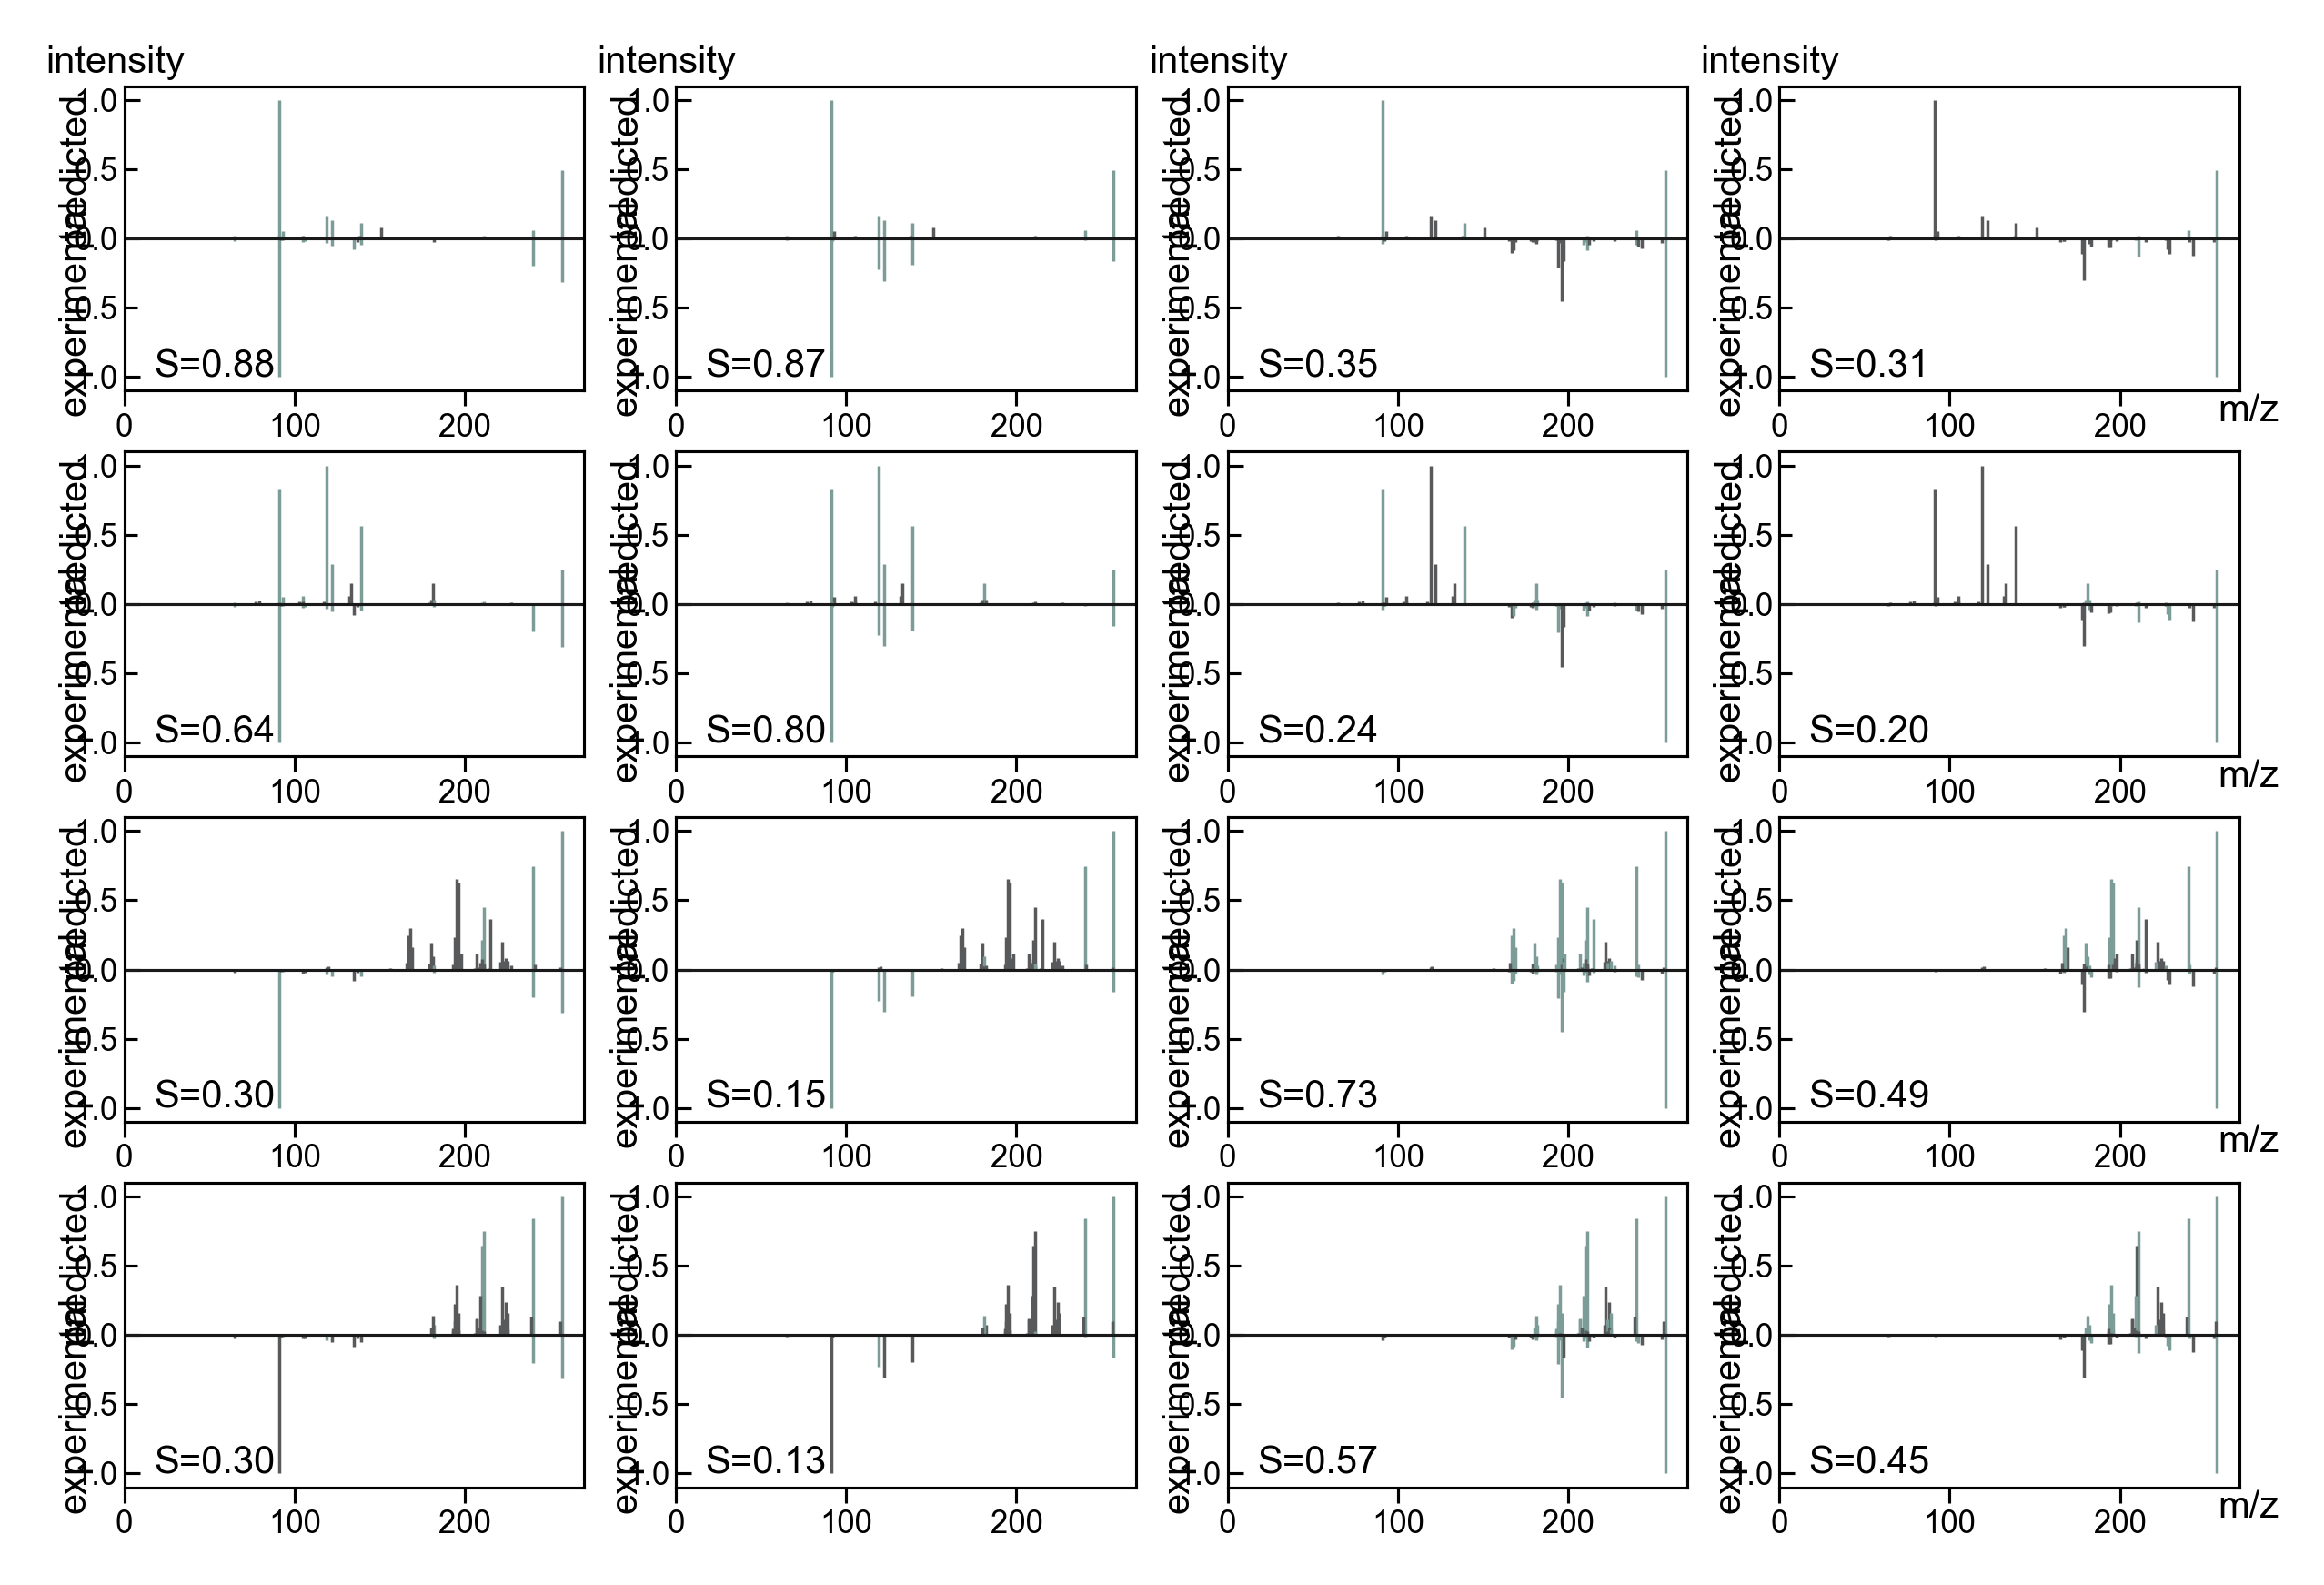

In [72]:
import itertools

all_smiles = ['C%12(CCCNC%13=CC=C(N(=O)=O)C=C%13)=CC=CC=C%12', 'CCC(NC6=CC=C(N(=O)=O)C=C6)C7=CC=CC=C7', 'CC(C)C%10=C(NC%11=CC=C(N(=O)=O)C=C%11)C=CC=C%10', 'CCC8=CC=CC(C)=C8NC9=CC=C(N(=O)=O)C=C9']
# all_feat_ids = ['6518', '6603', '6869', '7306']
# inp_mgf = '/home/runzhong/ms_collaborators/bo_reaction/all_nitro_and_iodo_20250404_iimn_fbmn.mgf'
all_feat_ids = ['10385', '9978', '10917', '9718']
inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250405_pool/all_nitro_and_iodo_20250411_sirius.mgf'


all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and entry[0]['FEATURE_ID'] in all_feat_ids)
}
all_specs = [feat_id_to_specs[id] for id in all_feat_ids]


fig, axes = plt.subplots(len(all_smiles), len(all_feat_ids), figsize=(1.5 * len(all_feat_ids), 1 * len(all_smiles)), dpi=500)
for i, j in itertools.product(range(len(all_smiles)), range(len(all_feat_ids))):
    ax = axes[i][j]
    visual_preds_compare(all_smiles[i], {'nan': all_specs[j]}, [30, 45, 60], 
                         nce=True, explain_npeaks=0, merge_ces=True, real_spec_type='raw', axes=ax, ignore_precursor=False)
    ax.set_title("")
    if j != len(all_smiles) - 1:
        ax.set_xlabel("")
    if i != 0:
        ax.set_ylabel("")
plt.savefig('bh_pool_nitro.pdf', bbox_inches='tight')

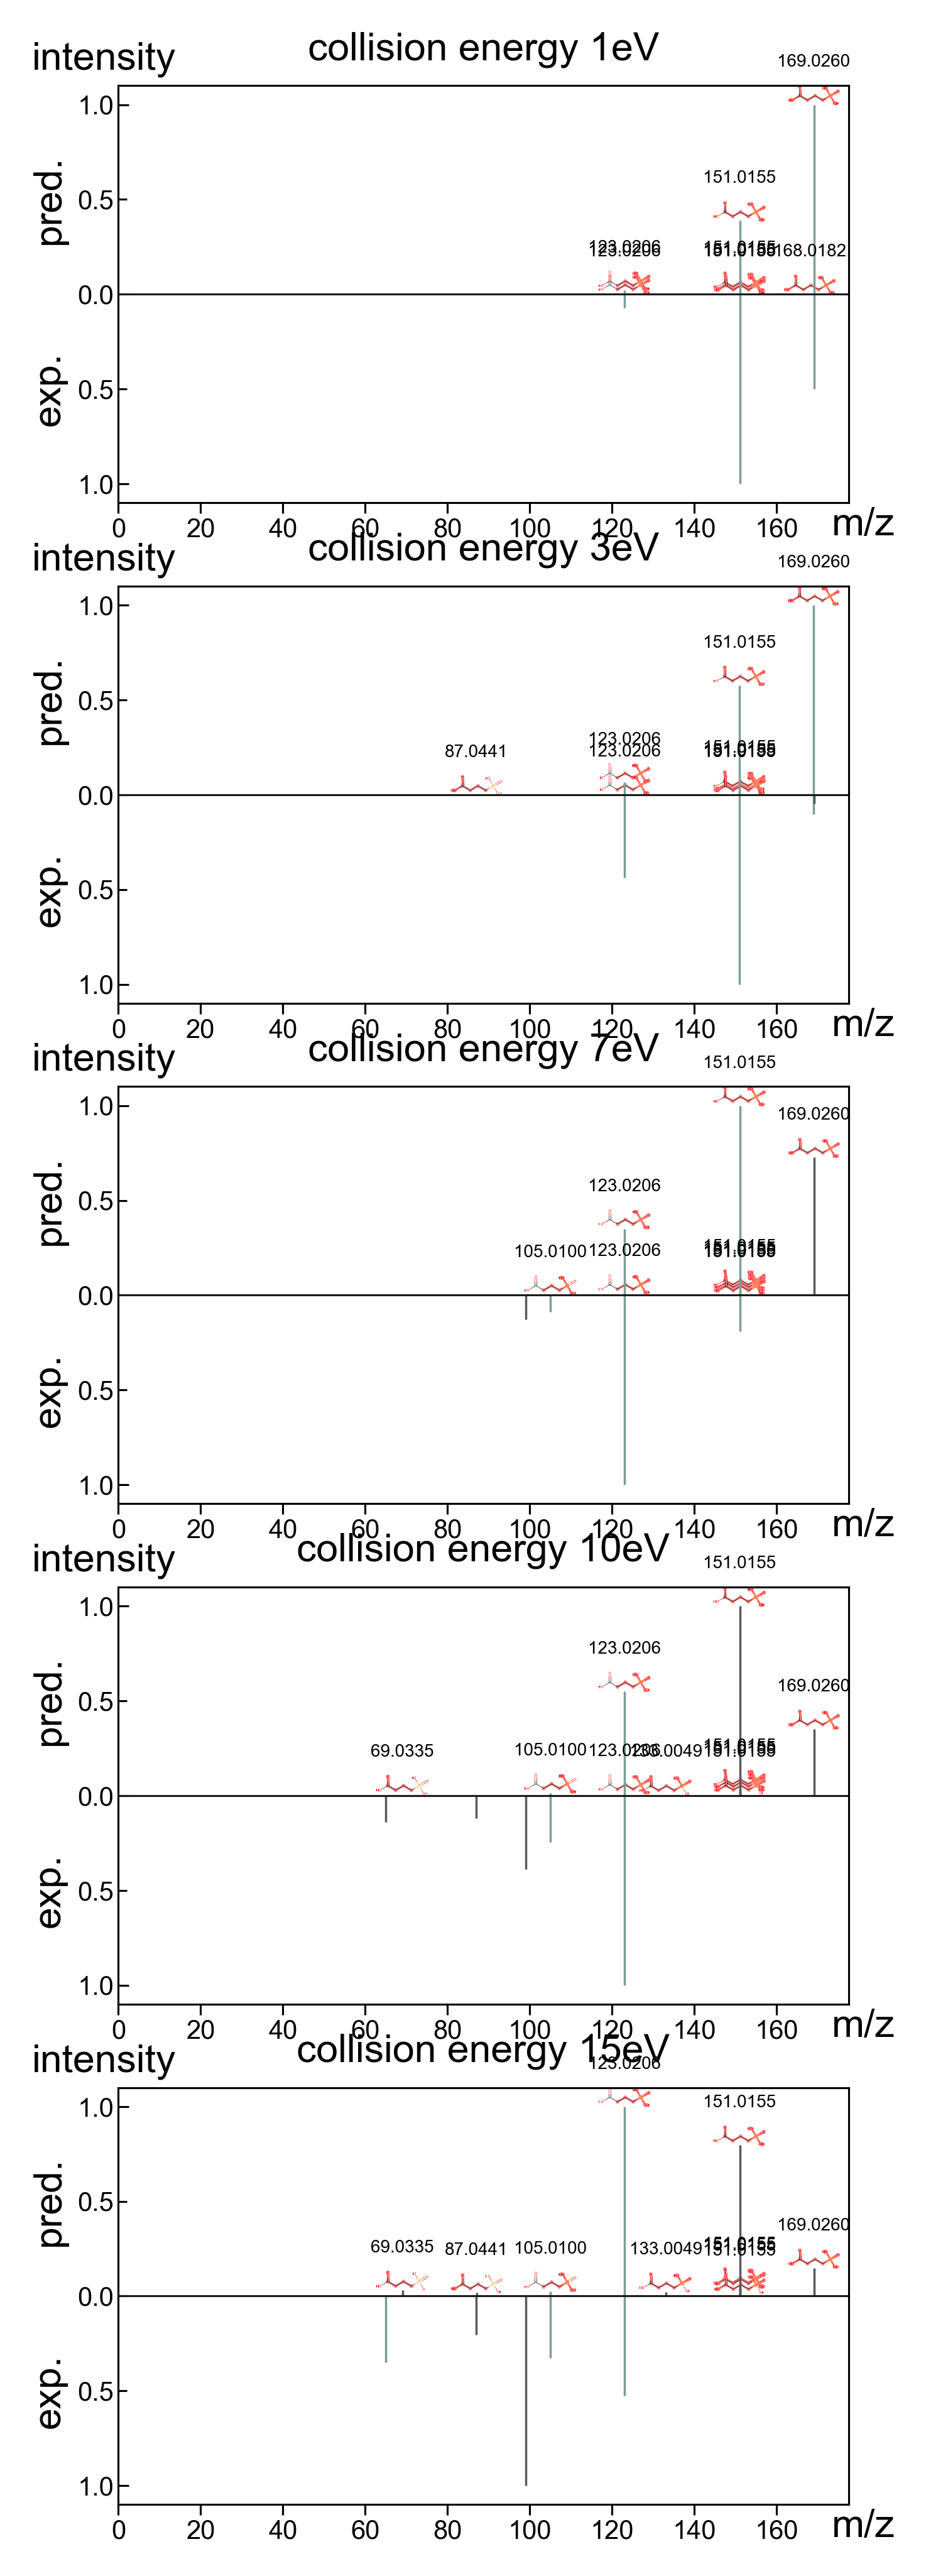

In [47]:
visual_preds_compare(r'C(CC(=O)O)CP(=O)(O)O',
                     f'nist_1144025',
                     [2, 10, 20, 30, 45], nce=True, explain_npeaks=10, real_spec_type='nist', name='phospho')

CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/acd079de8febc45b47f6d8610d0993db/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/acd079de8febc45b47f6d8610d0993db \
               --gpu \
               --adduct-shift


Global seed set to 42


2025-03-19 23:38:17,203 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/acd079de8febc45b47f6d8610d0993db/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/acd079de8febc45b47f6d8610d0993db
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2025-03-19 23:38:17,580 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt
2025-03-19 23:38:

  0%|          | 0/1 [00:00<?, ?it/s]

2025-03-19 23:38:23,750 INFO: There are 5 entries to process


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


2025-03-19 23:38:26,369 INFO: Program finished in: 9.193009614944458 seconds


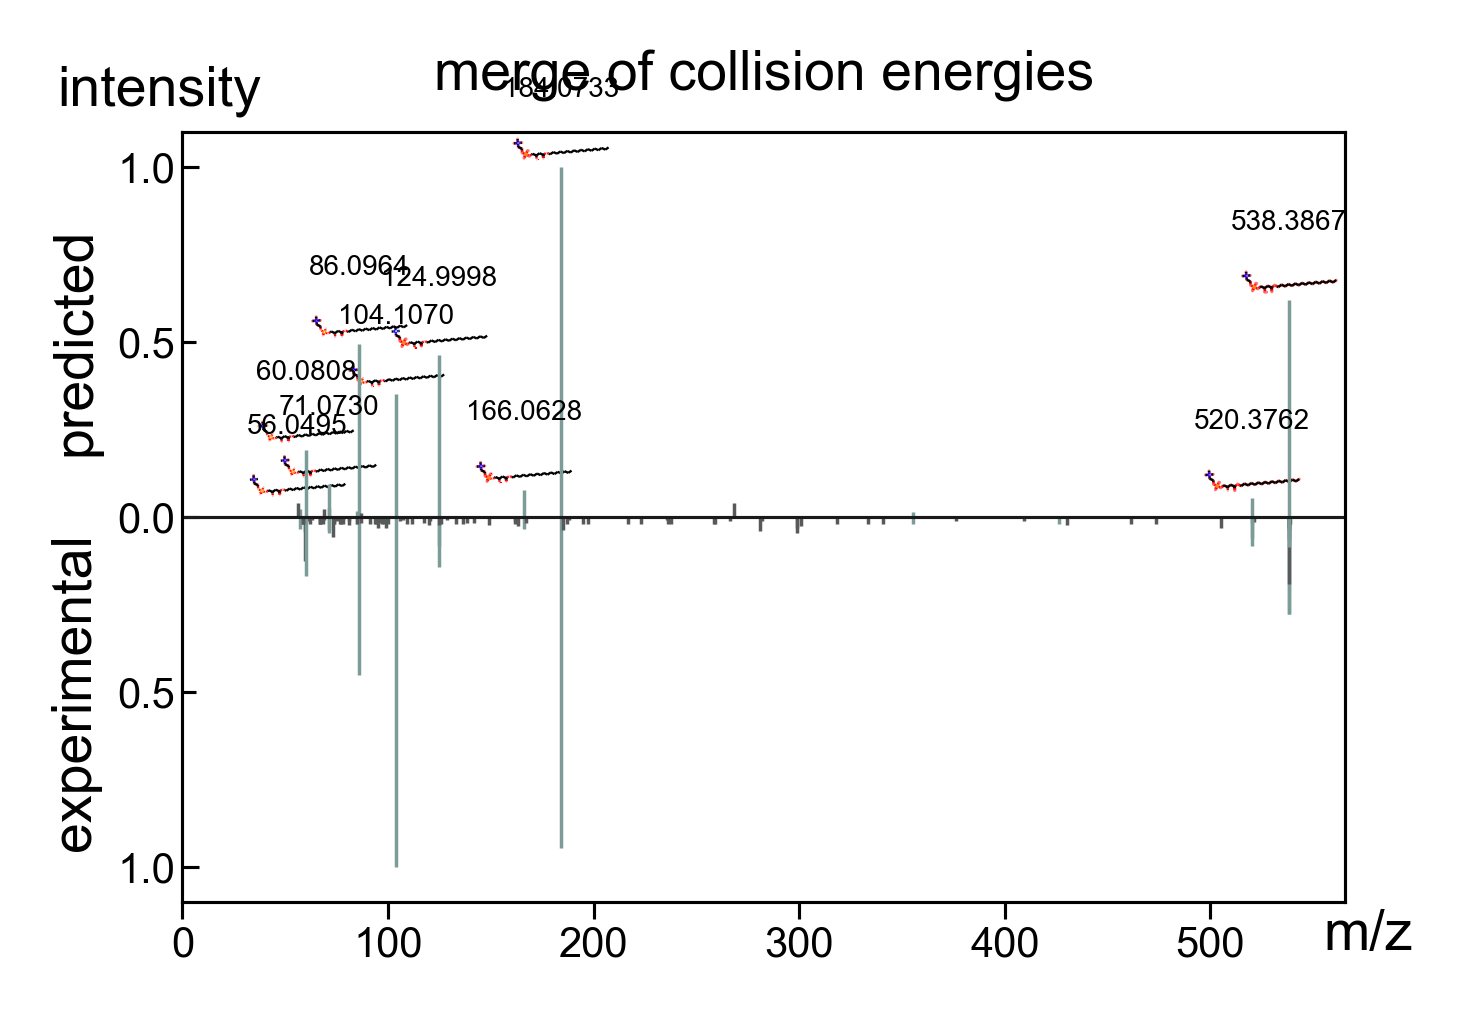

In [65]:
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)CC(OCCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'/home/roger/ms_collaborators/broad-Julian/spec_files/QI8894.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=10, merge_ces=True, real_spec_type='ms', name='lcp')